# **Network Science Project**

### TOPIC: Discussion about AI before and after ChatGPT introduction (30 novembre 2022)

Research questions:

1.  	Temporal difference before and after ChatGPT:

a.  	Network structure: centrality measures, closness: the most influential nodes and how the discussion has changes

b.  	Flow of information beetwenness

c.  	Community detection, subtopics and their temporal evolution

2.  	Average opinion, sentiment analysis
3.  	When the discussion was more important/active

# PT1: DATA LOADING and ORGANIZATION

In [ ]:
#Downloading Libraries
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import scipy.sparse as sps
from scipy.sparse import csr_matrix
!pip install praw
import praw
import praw.exceptions
!pip install louvain
import louvain
import igraph as ig
import time
import pickle
!pip install bertopic
from bertopic import BERTopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.9 MB/s eta 0:00:00


<ipython-input-1-ff5acba18aa6>:15: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 20.0 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.5 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039292 sha256=4e8fc87b1bf34323679e59fd14a9579b57be12b7f2f827cc6db176f95887e66c
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for umap-

In [ ]:
#Setting up the drive
from google.colab import drive
drive.mount('/content/drive')

results_folder = 'https://drive.google.com/drive/folders/1MH4AyXagVQQCHwySzOxX4EKgPZmXHMsj?usp=drive_link'

Mounted at /content/drive


In [ ]:
#Reddit Account: Cecilia
"""
REDDIT = praw.Reddit(
    client_id = 'AS8vmMKy4Q_o9Ps4hO87Ow',
    client_secret = 'HvYel907TZyenGTTKhAJ9syG5vQwNA',
    user_agent = 'Wonderful_Basil9426',
    check_for_async=False,
)
"""

#Reddit Account: Filippo

REDDIT = praw.Reddit(
    client_id ="H7ROsOW3K94OC5lTf5F-Bg",
    client_secret ="nW6G4ft7oRMN7WlTyMyV2czn7vEDTw",
    user_agent ="Test_api",
    check_for_async=False,
)

In [ ]:
# PT1 : Looking for Subreddits regarding Artificial Intelligence
query = 'Artificial Intelligence OR AI OR IA'
limit_num_subreddits = 100
IA_subreddits = REDDIT.subreddits.search(query, limit=limit_num_subreddits)

IA_df = pd.DataFrame(vars(subreddit) for subreddit in IA_subreddits) #vars: we need it to transform into dictionaries
print('Dataframe shape:',IA_df.shape)
print('Columns in the original DataFrame', len(IA_df.columns))

#We only need to know 'display_name' and 'subscriber' (we order the element for subscribers in descending order)
IA_df = IA_df[['display_name','subscribers']].sort_values(by='subscribers', ascending=False, ignore_index=True)
display(IA_df)

#We only consider the names of the subreddits (considering the subscribers)
list_subreddits_names = list(IA_df['display_name'])

Dataframe shape: (100, 105)
Columns in the original DataFrame 105


display_name  subscribers
0      Futurology   19742375.0
1     singularity    1915071.0
2          OpenAI    1091756.0
3      artificial     711617.0
4   uncannyvalley      86280.0
..            ...          ...
95  displacedbyAI         23.0
96       AI_Sales         22.0
97    memorize_ai         18.0
98          GadAI         16.0
99        kinkyAI          NaN

[100 rows x 2 columns]

In [ ]:
#PT2: Reading the posts for each subreddit

def read_posts(subreddit_name, tot_posts_to_retrieve, keywords, time_filter, sort_mode, batch_size=250):
  subreddit = REDDIT.subreddit(subreddit_name)
  #Since the subreddit looks for a limited number of posts each time (250=batch_size), we repeat the search using a cicle until completion
  posts = []
  retrieved_posts = 0
  after_param = ''

  while retrieved_posts < tot_posts_to_retrieve:
    remaining_posts = min(tot_posts_to_retrieve - retrieved_posts, batch_size)
    new_posts = list(subreddit.search(keywords,
                                 limit = remaining_posts,
                                 time_filter = time_filter,
                                 sort = sort_mode,
                                 params = {'after': after_param}
                                 ))
    if not new_posts:
      break #Nothing more to look for
    posts.extend(new_posts) #alternativa a posts.append(n_post for n_post in list(new_posts))
    retrieved_posts += len(new_posts)
    after_param = 't3_' + posts[-1].id #dice di cercare dopo l'ultimo

  posts_df = pd.DataFrame(vars(post) for post in posts)
  print(len(posts_df), ' posts retrieved out of ', tot_posts_to_retrieve)

  return posts_df

In [ ]:
#Applichiamo la funzione a ciascun subreddit considerato prima
TOT_POSTS_TO_RETRIEVE = 2000
time_filter = 'all' # "all", "day", "hour", "month", "week", or "year"
sort_mode = 'top' # "relevance", "hot", "top", "new", or "comments"
keywords = 'IA OR Artificial Intelligence'

dfs = []
for subreddit in list_subreddits_names:
  print(str(subreddit))
  if subreddit=='kinkyAI':
      break
  else:
      posts_subreddit = read_posts(subreddit, TOT_POSTS_TO_RETRIEVE, keywords, time_filter, sort_mode)
      dfs.append(posts_subreddit)

DF_IA_posts = pd.concat(dfs, ignore_index=True)
DF_IA_posts = DF_IA_posts[['id','created','subreddit','title','selftext','author','author_fullname','upvote_ratio','ups','num_comments']]
DF_IA_posts['created'] = [datetime.date.fromtimestamp(i) for i in DF_IA_posts['created']]

display(DF_IA_posts)

Futurology
237  posts retrieved out of  2000
singularity
238  posts retrieved out of  2000
OpenAI
237  posts retrieved out of  2000
artificial
231  posts retrieved out of  2000
uncannyvalley
3  posts retrieved out of  2000
MediaSynthesis
111  posts retrieved out of  2000
agi
237  posts retrieved out of  2000
reinforcementlearning
151  posts retrieved out of  2000
lexfridman
82  posts retrieved out of  2000
ChaiApp
34  posts retrieved out of  2000
AIfreakout
21  posts retrieved out of  2000
Cortex_Official
41  posts retrieved out of  2000
automation
35  posts retrieved out of  2000
AIAssisted
15  posts retrieved out of  2000
DefendingAIArt
60  posts retrieved out of  2000
ControlProblem
234  posts retrieved out of  2000
AIRemastered
0  posts retrieved out of  2000
AITX
130  posts retrieved out of  2000
gameai
64  posts retrieved out of  2000
aiclass
56  posts retrieved out of  2000
ClaudeAI
20  posts retrieved out of  2000
generativeAI
26  posts retrieved out of  2000
YodayoAI
0  posts 

id     created    subreddit  \
0      agk949  2019-01-16   Futurology   
1      7j1w9l  2017-12-11   Futurology   
2      cnwzlz  2019-08-09   Futurology   
3      8bguzb  2018-04-11   Futurology   
4      ktwedz  2021-01-09   Futurology   
...       ...         ...          ...   
3313  1aoo2yf  2024-02-12     AI_Sales   
3314  1aov425  2024-02-12     AI_Sales   
3315  19e9qom  2024-01-24     AI_Sales   
3316   fd87bd  2020-03-04  memorize_ai   
3317   dxxyw6  2019-11-18  memorize_ai   

                                                  title  \
0     A Future with Elon Musk’s Neuralink: His plan ...   
1     Nasa to hold major announcement after artifici...   
2     Society should shift towards a technology and ...   
3     Tesla CEO Elon Musk says social media, artific...   
4     Artificial Intelligence Finds Hidden Roads Thr...   
...                                                 ...   
3313                    Integrating AI into CRM Systems   
3314             Make AI Your Partner For Winning Sales   
3315  AI in Sales Automation: Your Initial Impressions?   
3316  Have You Ever Wanted a Repetition based App us...   
3317                       memorize_ai has been created   

                                               selftext              author  \
0                                                                      mvea   
1                                                                lughnasadh   
2     It seems that humanities' current purpose is l...          Bjornskald   
3                                                                      mvea   
4                                                                  Gari_305   
...                                                 ...                 ...   
3313  Consider the management of extensive customer ...             PNGstan   
3314  Integrating AI into CRM systems significantly ...     Icy-Relative502   
3315  What are your initial thoughts and considerati...  Original_Nerve6819   
3316  I got the answer it's [memorize.ai](https://me...         ProfSucrose   
3317  The official memorize.ai community! This is a ...            Kennyp0o   

     author_fullname  upvote_ratio    ups  num_comments  
0            t2_6hji          0.81  38453          4296  
1           t2_3pjww          0.91  29798          1273  
2           t2_hxda1          0.81  29328          3119  
3            t2_6hji          0.86  27506          1061  
4        t2_65fa26pr          0.96  26657           358  
...              ...           ...    ...           ...  
3313    t2_qbek67fho          1.00      6             2  
3314    t2_ef9s2hlca          0.86      5             4  
3315    t2_oyy1n1xsb          1.00      3             5  
3316     t2_3u2jqgnp          1.00      6             1  
3317     t2_10csilyz          0.72      3             0  

[3318 rows x 10 columns]

In [ ]:
# keep only those posts that have more than 200 ups
final_DF_IA_posts = DF_IA_posts.copy()
final_DF_IA_posts = final_DF_IA_posts.loc[final_DF_IA_posts['ups'] >= 50]
final_DF_IA_posts = final_DF_IA_posts.sort_values(by='created', ignore_index=True)
display(final_DF_IA_posts)

id     created    subreddit  \
0      xxvrf  2012-08-09   Futurology   
1      y9lm0  2012-08-15   Futurology   
2      ycbgz  2012-08-16   Futurology   
3      zq56m  2012-09-11   Futurology   
4     12m8ll  2012-11-04   Futurology   
..       ...         ...          ...   
869  1atbf2p  2024-02-17  singularity   
870  1atf87f  2024-02-17  singularity   
871  1asse29  2024-02-17       OpenAI   
872  1at3soq  2024-02-17  singularity   
873  1at1znb  2024-02-17       OpenAI   

                                                 title  \
0    I am Jerome Glenn. Ask me anything about runni...   
1    I am Luke Muehlhauser, CEO of the Singularity ...   
2                           The Scale of Intelligence:   
3    I'm Dr. Ben Goertzel, Artificial General Intel...   
4    "Biological Intelligence is a Fleeting Phase i...   
..                                                 ...   
869                      SORA shattered my AI timeline   
870  Legendary chip architect Jim Keller responds t...   
871                  The Ultimate Test of Intelligence   
872  Someone is testing a model/system that signifi...   
873  Sam Altman Wants US Gov to Give Greenlight for...   

                                              selftext                author  \
0    Hi everyone, \n\nMy name is Jason and I’ve bee...             bostoniaa   
1    [Verification](http://i.imgur.com/Si3PV.jpg).\...              lukeprog   
2                                                                  Xenophon1   
3                                                                bengoertzel   
4                                                                  bostoniaa   
..                                                 ...                   ...   
869  The kind of video generation we’re seeing now ...  Glittering-Neck-2505   
870  Unfortunately Sam Altman won't elaborate why h...  Apprehensive-Part979   
871                                   can you pass it?            assymetry1   
872  A few months ago, the people at Huggingface, w...   MajesticIngenuity32   
873                                                            sinkmyteethin   

    author_fullname  upvote_ratio   ups  num_comments  
0          t2_641wf          0.97   503           641  
1          t2_2dw9w          0.96  1408          2097  
2          t2_3t8cy          0.83   590           105  
3          t2_8yyst          0.98   327           217  
4          t2_641wf          0.97   484            60  
..              ...           ...   ...           ...  
869     t2_crsnu03k          0.92   430           237  
870     t2_6macf052          0.95   183            89  
871     t2_1ld2fdt4          0.95   760           113  
872    t2_5dep8jot8          0.89   200            51  
873        t2_f4ixa          0.95   102            34  

[874 rows x 10 columns]

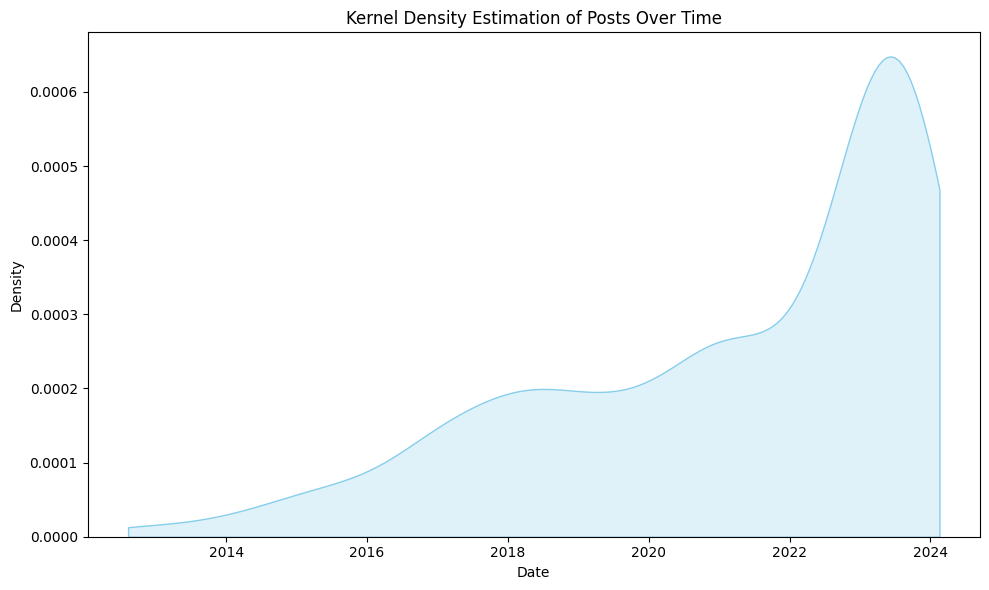

In [ ]:
def show_trend(df, column='created'):
    df.dropna(subset=[column], inplace=True)

    plt.figure(figsize=(10, 6))
    sns.kdeplot(pd.to_datetime(df[column], errors='coerce'), color='skyblue', fill=True, cut=0)
    plt.title('Kernel Density Estimation of Posts Over Time')
    plt.xlabel('Date')
    plt.ylabel('Density')
    plt.xticks(rotation=45, minor=True)
    plt.tight_layout()
    plt.show()

show_trend(final_DF_IA_posts)

# PT2: DATA CLEANING

In [ ]:
import re
import string
from bs4 import BeautifulSoup
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

!pip install emoji
import emoji
!pip install contractions
import contractions
!pip install autocorrect
from autocorrect import Speller
!pip install unidecode
from unidecode import unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=81b3a7189a5d288d43be65290fc39cecc62d6a8b6447b09d4313ea50a586d760
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.3 MB/s eta 0:00:00


In [ ]:
#%run "drive/MyDrive/Colab Notebooks/NSlab2/cleaning_mod.ipynb"

#SUPERFICIAL CLEANING

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
}

"""
Function created by the tutors in the labs
"""
def superficial_cleaning(selftext):

    selftext = contractions.fix(selftext)

    # Remove any HTML tag
    soup = BeautifulSoup(selftext, "html.parser")
    selftext = soup.get_text(separator=" ")

    # Remove any text inside square brackets
    selftext = re.sub(r'\[.*?\]', '', selftext)

    # Remove any website links
    selftext = re.sub(r'http\S+', '', selftext)
    selftext = re.sub(r'www.\S+', '', selftext)
    selftext = selftext.replace('. com', '.com')
    selftext = re.sub(r"\ [A-Za-z]*\.com", " ", selftext)

    # Remove any emojis
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U0001F92C"             # 🥴
                       u"\u2764"                 # ❤️
                       u"\u2764\ufe0f"           # ❤️ (with variation selector)
                       u"\u2060"
                       "]+", flags=re.UNICODE)
    selftext = emoji_pattern.sub(r'', selftext)

    # Remove '&amp;#x200B;\n\'
    selftext = re.sub(r'&amp;#x200B;\n\\', ' ', selftext)
    selftext = re.sub(r'‚Äú', ' ', selftext)
    selftext = re.sub(r'‚Äô', "’", selftext)

    # Remove accented characters from text using unidecode
    selftext = unidecode(selftext)

    # Convert text to lower case
    selftext = selftext.lower()

    # Remove double spaces, newlines, tabs, and combinations
    selftext = re.sub(r' +', ' ', selftext)
    selftext = re.sub(r'\s{2,}', ' ', selftext)
    selftext = re.sub(r'&gt;', ' ', selftext)
    selftext = selftext.replace('-', ' ')
    selftext = selftext.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')

    # Remove any numbers, hashtags and mentions - are dealt with separately
    selftext = re.sub(r'\d+', ' ', selftext)
    selftext = re.sub(r'#\w+', '', selftext)
    selftext = re.sub(r'@\w+', '', selftext)

    # Reduce repetition to two characters for alphabets and to
    # one character for punctuations
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    selftext = Pattern_alpha.sub(r"\1\1", selftext)
    selftext = Pattern_Punct.sub(r'\1', selftext)
    selftext = re.sub(' {2,}',' ', selftext)

    # Expand contractions
    list_Of_tokens = selftext.split(' ')
    for Word in list_Of_tokens:
         if Word in CONTRACTION_MAP:
                list_Of_tokens = [item.replace(Word, CONTRACTION_MAP[Word]) for item in list_Of_tokens]
    selftext = ' '.join(str(e) for e in list_Of_tokens)

    # Remove any special character (After hastages & mentions)
    selftext = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', selftext)
    selftext = re.sub(r'%', ' ', selftext)

    # Removing numbers and punctuations
    selftext = re.sub(r"[^a-zA-Z:$-,%.?!]+", ' ', selftext)
    selftext = re.sub(r'[^\w\s]',' ',selftext)

    # Remove extra whitespaces from the text
    pattern = re.compile(r'\s+')
    Without_whitespace = re.sub(pattern, ' ', selftext)
    selftext = Without_whitespace.replace('?', ' ? ').replace(')', ') ')

    # Check for spellings in English language - very slow
    #spell = Speller(lang='en')
    #selftext = spell(selftext)
    #selftext = re.sub(r'[^\w\s]', '', selftext)

    return selftext

def remove_single_letters(text):
    words = text.split()
    filtered_words = [word for word in words if len(word) > 1]
    return ' '.join(filtered_words)

In [ ]:
final_DF_IA_posts["text_sup_clean"] = final_DF_IA_posts["title"].apply(superficial_cleaning)
final_DF_IA_posts["text_sup_clean"] = final_DF_IA_posts["text_sup_clean"].apply(remove_single_letters)

In [ ]:
#DEEP CLEANING
POS_KEEP = ['ADJ','ADV','NOUN','PROPN','VERB']

def deep_cleaning(text, with_pos=True):
  #Lemmatize + POS with Spacy - works on polished data
  if with_pos:
    outtext = [' '.join([token.lemma_,token.pos_]) for token in nlp(text) if token.pos_ in POS_KEEP]
  else:
    outtext = ' '.join([token.lemma_ for token in nlp(text) if token.pos_ in POS_KEEP])
  return outtext

In [ ]:
final_DF_IA_posts["text_deep_clean"] = final_DF_IA_posts["text_sup_clean"].apply(deep_cleaning, with_pos=False)
final_DF_IA_posts["text_deep_clean_pos"] = final_DF_IA_posts["text_sup_clean"].apply(deep_cleaning)

In [ ]:
display(final_DF_IA_posts)

id     created    subreddit  \
0      xxvrf  2012-08-09   Futurology   
1      y9lm0  2012-08-15   Futurology   
2      ycbgz  2012-08-16   Futurology   
3      zq56m  2012-09-11   Futurology   
4     12m8ll  2012-11-04   Futurology   
..       ...         ...          ...   
869  1atbf2p  2024-02-17  singularity   
870  1atf87f  2024-02-17  singularity   
871  1asse29  2024-02-17       OpenAI   
872  1at3soq  2024-02-17  singularity   
873  1at1znb  2024-02-17       OpenAI   

                                                 title  \
0    I am Jerome Glenn. Ask me anything about runni...   
1    I am Luke Muehlhauser, CEO of the Singularity ...   
2                           The Scale of Intelligence:   
3    I'm Dr. Ben Goertzel, Artificial General Intel...   
4    "Biological Intelligence is a Fleeting Phase i...   
..                                                 ...   
869                      SORA shattered my AI timeline   
870  Legendary chip architect Jim Keller responds t...   
871                  The Ultimate Test of Intelligence   
872  Someone is testing a model/system that signifi...   
873  Sam Altman Wants US Gov to Give Greenlight for...   

                                              selftext                author  \
0    Hi everyone, \n\nMy name is Jason and I’ve bee...             bostoniaa   
1    [Verification](http://i.imgur.com/Si3PV.jpg).\...              lukeprog   
2                                                                  Xenophon1   
3                                                                bengoertzel   
4                                                                  bostoniaa   
..                                                 ...                   ...   
869  The kind of video generation we’re seeing now ...  Glittering-Neck-2505   
870  Unfortunately Sam Altman won't elaborate why h...  Apprehensive-Part979   
871                                   can you pass it?            assymetry1   
872  A few months ago, the people at Huggingface, w...   MajesticIngenuity32   
873                                                            sinkmyteethin   

    author_fullname  upvote_ratio   ups  num_comments  \
0          t2_641wf          0.97   503           641   
1          t2_2dw9w          0.96  1408          2097   
2          t2_3t8cy          0.83   590           105   
3          t2_8yyst          0.98   327           217   
4          t2_641wf          0.97   484            60   
..              ...           ...   ...           ...   
869     t2_crsnu03k          0.92   430           237   
870     t2_6macf052          0.95   183            89   
871     t2_1ld2fdt4          0.95   760           113   
872    t2_5dep8jot8          0.89   200            51   
873        t2_f4ixa          0.95   102            34   

                                        text_sup_clean  \
0    am jerome glenn ask me anything about running ...   
1    am luke muehlhauser ceo of the singularity ins...   
2                            the scale of intelligence   
3    am dr ben goertzel artificial general intellig...   
4    biological intelligence is fleeting phase in t...   
..                                                 ...   
869                      sora shattered my ai timeline   
870  legendary chip architect jim keller responds t...   
871                  the ultimate test of intelligence   
872  someone is testing model system that significa...   
873  sam altman wants us gov to give greenlight for...   

                                       text_deep_clean  \
0    jerome glenn ask run international futurist or...   
1    luke muehlhauser ceo singularity institute art...   
2                                   scale intelligence   
3    dr ben goertzel artificial general intelligenc...   
4    biological intelligence fleeting phase evoluti...   
..                                                 ...   
869                           sora shatter ai timeline   
870  legendar

In [ ]:
#FINDING HASHTAGS
def get_hashtags(text):
    # Convert text to lower case - needed since it works on the original data
    text = text.lower()
    # Get hashtags
    hashtag_list = re.findall("#(\w+)", text)
    if len(hashtag_list) == 0:
      return np.NaN
    return hashtag_list

In [ ]:
final_DF_IA_posts['hashtags'] = final_DF_IA_posts['title'].apply(get_hashtags)
hashtag_IA_posts = final_DF_IA_posts[final_DF_IA_posts['hashtags'].notna()]

In [ ]:
display(final_DF_IA_posts)
display(hashtag_IA_posts)

id     created    subreddit  \
0      xxvrf  2012-08-09   Futurology   
1      y9lm0  2012-08-15   Futurology   
2      ycbgz  2012-08-16   Futurology   
3      zq56m  2012-09-11   Futurology   
4     12m8ll  2012-11-04   Futurology   
..       ...         ...          ...   
869  1atbf2p  2024-02-17  singularity   
870  1atf87f  2024-02-17  singularity   
871  1asse29  2024-02-17       OpenAI   
872  1at3soq  2024-02-17  singularity   
873  1at1znb  2024-02-17       OpenAI   

                                                 title  \
0    I am Jerome Glenn. Ask me anything about runni...   
1    I am Luke Muehlhauser, CEO of the Singularity ...   
2                           The Scale of Intelligence:   
3    I'm Dr. Ben Goertzel, Artificial General Intel...   
4    "Biological Intelligence is a Fleeting Phase i...   
..                                                 ...   
869                      SORA shattered my AI timeline   
870  Legendary chip architect Jim Keller responds t...   
871                  The Ultimate Test of Intelligence   
872  Someone is testing a model/system that signifi...   
873  Sam Altman Wants US Gov to Give Greenlight for...   

                                              selftext                author  \
0    Hi everyone, \n\nMy name is Jason and I’ve bee...             bostoniaa   
1    [Verification](http://i.imgur.com/Si3PV.jpg).\...              lukeprog   
2                                                                  Xenophon1   
3                                                                bengoertzel   
4                                                                  bostoniaa   
..                                                 ...                   ...   
869  The kind of video generation we’re seeing now ...  Glittering-Neck-2505   
870  Unfortunately Sam Altman won't elaborate why h...  Apprehensive-Part979   
871                                   can you pass it?            assymetry1   
872  A few months ago, the people at Huggingface, w...   MajesticIngenuity32   
873                                                            sinkmyteethin   

    author_fullname  upvote_ratio   ups  num_comments  \
0          t2_641wf          0.97   503           641   
1          t2_2dw9w          0.96  1408          2097   
2          t2_3t8cy          0.83   590           105   
3          t2_8yyst          0.98   327           217   
4          t2_641wf          0.97   484            60   
..              ...           ...   ...           ...   
869     t2_crsnu03k          0.92   430           237   
870     t2_6macf052          0.95   183            89   
871     t2_1ld2fdt4          0.95   760           113   
872    t2_5dep8jot8          0.89   200            51   
873        t2_f4ixa          0.95   102            34   

                                        text_sup_clean  \
0    am jerome glenn ask me anything about running ...   
1    am luke muehlhauser ceo of the singularity ins...   
2                            the scale of intelligence   
3    am dr ben goertzel artificial general intellig...   
4    biological intelligence is fleeting phase in t...   
..                                                 ...   
869                      sora shattered my ai timeline   
870  legendary chip architect jim keller responds t...   
871                  the ultimate test of intelligence   
872  someone is testing model system that significa...   
873  sam altman wants us gov to give greenlight for...   

                                       text_deep_clean  \
0    jerome glenn ask run international futurist or...   
1    luke muehlhauser ceo singularity institute art...   
2                                   scale intelligence   
3    dr ben goertzel artificial general intelligenc...   
4    biological intelligence fleeting phase evoluti...   
..                                                 ...   
869                           sora shatter ai timeline   
870  legendar

id     created   subreddit  \
462   vyzk3j  2022-07-14  lexfridman   
693  1525f5a  2023-07-17  lexfridman   
703  15fj7cr  2023-08-01  lexfridman   

                                                 title selftext  \
462  Richard Haier: IQ Tests, Human Intelligence, a...            
693  Yuval Noah Harari: Human Nature, Intelligence,...            
703  Joscha Bach: Life, Intelligence, Consciousness...            

               author author_fullname  upvote_ratio  ups  num_comments  \
462       natnurtniet     t2_a9f0zv00          0.98   50            51   
693  morpheusuniverse     t2_8x33yaxv          0.96  131           104   
703        neuralnet2     t2_vpsiqbxx          0.98   65            70   

                                        text_sup_clean  \
462  richard haier iq tests human intelligence and ...   
693  yuval noah harari human nature intelligence po...   
703  joscha bach life intelligence consciousness ai...   

                                       text_deep_clean  \
462  richard haier iq test human intelligence group...   
693  yuval noah harari human nature intelligence po...   
703  joscha bach life intelligence consciousness ai...   

                                   text_deep_clean_pos hashtags  
462  [richard PROPN, haier PROPN, iq PROPN, test VE...    [302]  
693  [yuval PROPN, noah PROPN, harari PROPN, human ...    [390]  
703  [joscha PROPN, bach PROPN, life PROPN, intelli...    [392]

In [ ]:
#Printing the title for the posts with hashtags
for title, hashtags in zip(hashtag_IA_posts['title'], hashtag_IA_posts['hashtags']):
  print(title, hashtags)
  print('\n')
#NOT INTERESTING RESULTS

Richard Haier: IQ Tests, Human Intelligence, and Group Differences | Lex Fridman Podcast #302 ['302']


Yuval Noah Harari: Human Nature, Intelligence, Power, and Conspiracies | Lex Fridman Podcast #390 ['390']


Joscha Bach: Life, Intelligence, Consciousness, AI & the Future of Humans | Lex Fridman Podcast #392 ['392']




# PT3: TEMPORAL DIVISION PRE AND POST CHAT GPT (30/11/2022)

In [ ]:
final_DF_IA_posts['created'] = pd.to_datetime(final_DF_IA_posts['created'])

# Convert datetime.date to Timestamp for comparison
pre_chatGPT = final_DF_IA_posts[final_DF_IA_posts['created'] < pd.to_datetime(datetime.date(2022, 11, 30))]

pre_chatGPT = pre_chatGPT.sort_values(by='created', ignore_index=True)
display(pre_chatGPT)

id    created    subreddit  \
0     xxvrf 2012-08-09   Futurology   
1     y9lm0 2012-08-15   Futurology   
2     ycbgz 2012-08-16   Futurology   
3     zq56m 2012-09-11   Futurology   
4    12m8ll 2012-11-04   Futurology   
..      ...        ...          ...   
497  z3epfb 2022-11-24   Futurology   
498  z48d8h 2022-11-25  singularity   
499  z57td9 2022-11-26   artificial   
500  z6zi12 2022-11-28       OpenAI   
501  z7wfp8 2022-11-29  singularity   

                                                 title  \
0    I am Jerome Glenn. Ask me anything about runni...   
1    I am Luke Muehlhauser, CEO of the Singularity ...   
2                           The Scale of Intelligence:   
3    I'm Dr. Ben Goertzel, Artificial General Intel...   
4    "Biological Intelligence is a Fleeting Phase i...   
..                                                 ...   
497  A programmer is suing Microsoft, GitHub and Op...   
498  A programmer is suing Microsoft, GitHub and Op...   
499  This Invisible Sweater Developed by the Univer...   
500       Artificial Intelligence replies to my emails   
501      Pinnacle Of Artificial intelligence (for now)   

                                              selftext           author  \
0    Hi everyone, \n\nMy name is Jason and I’ve bee...        bostoniaa   
1    [Verification](http://i.imgur.com/Si3PV.jpg).\...         lukeprog   
2                                                             Xenophon1   
3                                                           bengoertzel   
4                                                             bostoniaa   
..                                                 ...              ...   
497                                                           izumi3682   
498                                                     Desi___Gigachad   
499                                                            ai-lover   
500                                                             tifa2up   
501                                                            Pro_RazE   

    author_fullname  upvote_ratio   ups  num_comments  \
0          t2_641wf          0.97   503           641   
1          t2_2dw9w          0.96  1408          2097   
2          t2_3t8cy          0.83   590           105   
3          t2_8yyst          0.98   327           217   
4          t2_641wf          0.97   484            60   
..              ...           ...   ...           ...   
497        t2_bwpxx          0.93  6713           792   
498     t2_jpumdgyz          0.94   350           223   
499     t2_2wsvqwhg          0.96   167             6   
500     t2_1wzu8s8m          0.98    57             7   
501        t2_gb5r4          0.97   521            31   

                                        text_sup_clean  \
0    am jerome glenn ask me anything about running ...   
1    am luke muehlhauser ceo of the singularity ins...   
2                            the scale of intelligence   
3    am dr ben goertzel artificial general intellig...   
4    biological intelligence is fleeting phase in t...   
..                                                 ...   
497  programmer is suing microsoft github and opena...   
498  programmer is suing microsoft github and opena...   
499  this invisible sweater developed by the univer...   
500       artificial intelligence replies to my emails   
501        pinnacle of artificial intelligence for now   

                                       text_deep_clean  \
0    jerome glenn ask run international futurist or...   
1    luke muehlhauser ceo singularity institute art...   
2                                   scale intelligence   
3    dr ben goertzel artificial general intelligenc...   
4    biological intelligence fleeting phase evoluti...   
..                                                 ...   
497  programmer sue microsoft github openai artific...   
498  programmer sue microsoft github openai artific...   
499  invisible sweater develop univers

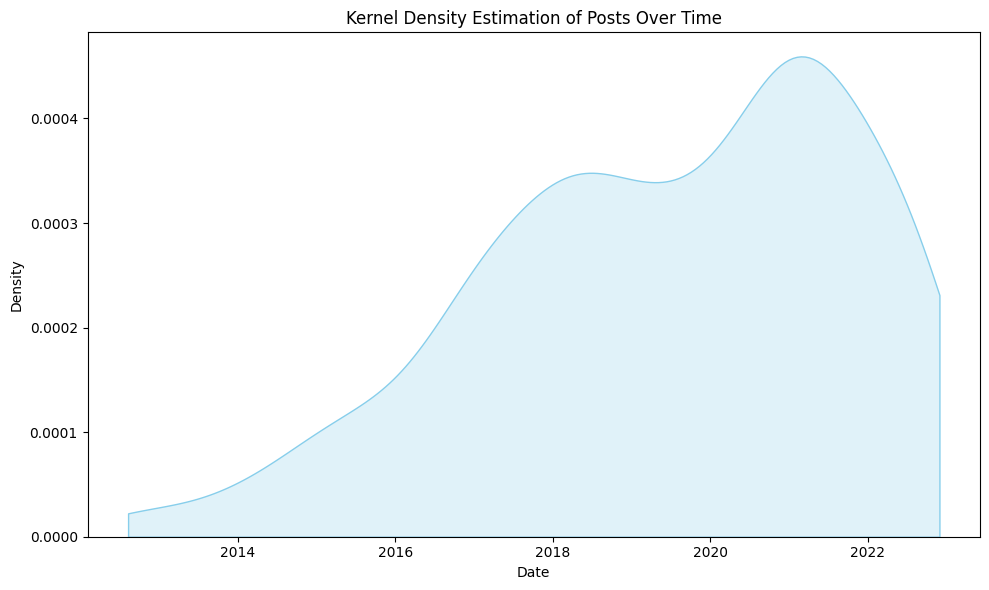

In [ ]:
show_trend(pre_chatGPT)

In [ ]:
post_chatGPT = final_DF_IA_posts[final_DF_IA_posts['created'] >= pd.to_datetime(datetime.date(2022,11,30))]
post_chatGPT = post_chatGPT.sort_values(by='created', ignore_index=True)
post_chatGPT

id    created    subreddit  \
0     z9ndaz 2022-12-01       OpenAI   
1     zb1nmu 2022-12-02  singularity   
2     zcgabn 2022-12-04   artificial   
3     zcfrc1 2022-12-04       OpenAI   
4     zeem4t 2022-12-06   lexfridman   
..       ...        ...          ...   
367  1asse29 2024-02-17       OpenAI   
368  1at3soq 2024-02-17  singularity   
369  1atbf2p 2024-02-17  singularity   
370  1atf87f 2024-02-17  singularity   
371  1at1znb 2024-02-17       OpenAI   

                                                 title  \
0    Top 10 Skills to Learn before AI takes over ac...   
1             Asking ChatGPT to draw its sense of self   
2    Disney Researchers Have Developed An Artificia...   
3    ChatGPT describes how it would take over the w...   
4                 Lex helped me appreciate Ben Shapiro   
..                                                 ...   
367                  The Ultimate Test of Intelligence   
368  Someone is testing a model/system that signifi...   
369                      SORA shattered my AI timeline   
370  Legendary chip architect Jim Keller responds t...   
371  Sam Altman Wants US Gov to Give Greenlight for...   

                                              selftext                author  \
0    Prompt:  top 10 skills to learn before AI take...                uroozz   
1                                                               micahdjt1221   
2                                                                   ai-lover   
3    ChatGPT describes how it would take over the w...             cloudd901   
4    Just listened to Lex’s podcast with Ben & for ...         DunAbyssinian   
..                                                 ...                   ...   
367                                   can you pass it?            assymetry1   
368  A few months ago, the people at Huggingface, w...   MajesticIngenuity32   
369  The kind of video generation we’re seeing now ...  Glittering-Neck-2505   
370  Unfortunately Sam Altman won't elaborate why h...  Apprehensive-Part979   
371                                                            sinkmyteethin   

    author_fullname  upvote_ratio  ups  num_comments  \
0         t2_3x6an8          0.98   50            11   
1        t2_4fcjtj9          0.98  384            52   
2       t2_2wsvqwhg          0.98  298            16   
3          t2_ioo4e          0.99   89            24   
4        t2_d2d5d7p          0.80  121           110   
..              ...           ...  ...           ...   
367     t2_1ld2fdt4          0.95  760           113   
368    t2_5dep8jot8          0.89  200            51   
369     t2_crsnu03k          0.92  430           237   
370     t2_6macf052          0.95  183            89   
371        t2_f4ixa          0.95  102            34   

                                        text_sup_clean  \
0    top skills to learn before ai takes over accor...   
1             asking chatgpt to draw its sense of self   
2    disney researchers have developed an artificia...   
3    chatgpt describes how it would take over the w...   
4                 lex helped me appreciate ben shapiro   
..                                                 ...   
367                  the ultimate test of intelligence   
368  someone is testing model system that significa...   
369                      sora shattered my ai timeline   
370  legendary chip architect jim keller responds t...   
371  sam altman wants us gov to give greenlight for...   

                                       text_deep_clean  \
0               top skill learn ai take accord chatgpt   
1                          ask chatgpt draw sense self   
2    disney researcher develop artificial intellige...   
3                          chatgpt describe take world   
4                      lex help appreciate ben shapiro   
..                                                 ...   
367                         ultimate test intelligence   
368  test model system significantly 

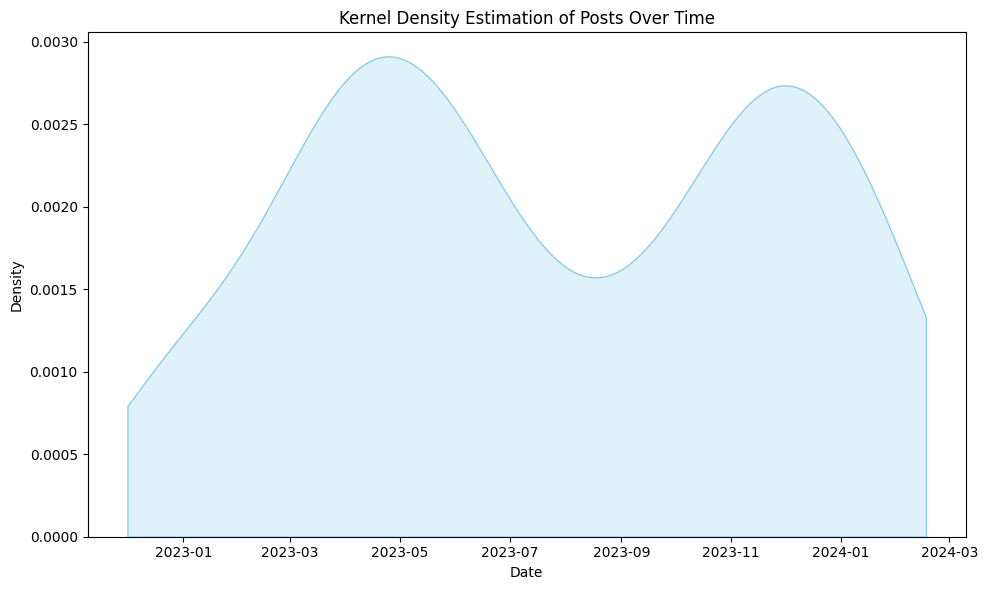

In [ ]:
show_trend(post_chatGPT)

In [ ]:
def top_n_cited_dates(df, date_column, n=5):

    # Group by date_column and count occurrences, then sort by counts in descending order
    date_counts = df.groupby(date_column).size().reset_index(name='counts')
    date_counts = date_counts.sort_values(by='counts', ascending=False, ignore_index = True)

    # Get the top n most cited dates
    top_dates = date_counts.head(n)

    return top_dates

top_n_cited_dates(post_chatGPT, date_column='created', n=5)

created  counts
0 2023-11-23       7
1 2024-02-17       5
2 2023-05-01       5
3 2023-11-22       5
4 2023-05-02       5

**28 aprile 2023**
ChatGpt torna disponibile in Italia.

**2 maggio 2023**
Geoffrey Hinton, uno dei “padrini” della moderna intelligenza artificiale, premiato nel 2018 con il Turing Award - una sorta di Premio Nobel dell’informatica - lascia Google, l’azienda per cui lavorava da dieci anni.

**21 novembre 2023**
In seguito alle dimissioni del Cda di OpenAI, Sam Altman torna alla guida dell’azienda.

**17 febbraio 2024**
ChatGPT annuncia la possibilità di "ricordare" le precedenti interazioni con il singolo utente

In [ ]:
top_n_cited_dates(pre_chatGPT, date_column='created', n=5)

created  counts
0 2014-01-27       4
1 2019-12-28       2
2 2017-01-16       2
3 2021-09-17       2
4 2017-03-18       2

**26 gennaio 2014**
Google annuncia l'acquisizione per 500 milioni di dollari e la società viene ribattezzata Google DeepMind, mantenendo questo nome per i successivi due anni

# PT4: CENTRALITY AND COMMUNITY ASSIGNMENT

In [ ]:
print(final_DF_IA_posts['text_deep_clean_pos'])
print(final_DF_IA_posts['text_deep_clean'])

0      [jerome PROPN, glenn PROPN, ask VERB, run VERB...
1      [luke PROPN, muehlhauser PROPN, ceo NOUN, sing...
2                        [scale NOUN, intelligence NOUN]
3      [dr PROPN, ben PROPN, goertzel PROPN, artifici...
4      [biological ADJ, intelligence NOUN, fleeting A...
                             ...                        
869    [sora PROPN, shatter VERB, ai NOUN, timeline N...
870    [legendary ADJ, chip NOUN, architect NOUN, jim...
871         [ultimate ADJ, test NOUN, intelligence NOUN]
872    [test VERB, model NOUN, system NOUN, significa...
873    [sam PROPN, altman PROPN, want VERB, gov PROPN...
Name: text_deep_clean_pos, Length: 874, dtype: object
0      jerome glenn ask run international futurist or...
1      luke muehlhauser ceo singularity institute art...
2                                     scale intelligence
3      dr ben goertzel artificial general intelligenc...
4      biological intelligence fleeting phase evoluti...
                             ...  

In [ ]:
def words_documents_analysis(df):
  #Creo la lista delle parole --> Words
  #Devo cercare per ogni sottoelemento del DF (in particolare la parte di text_deep_clean_pos) = a una lista di parole --> devo fare unique per evitare ripetizioni
  #usiamo il pos perchè vogliamo le parole con la loro assegnazione (potrebbero esserci parole che potenzialmente potrebbero appartenere a pos diversi)
  words = np.unique([word for subelement in df['text_deep_clean_pos'] for word in subelement])
  #Dizionario delle parole
  # words dictionary
  words_dict = dict(zip(words,range(len(words))))

  #Invece per la lista dei documenti --> documents
  #Sono gli ID dei post
  documents = np.unique([ids for ids in df['id']])

  #Calcoliamo la OCCURENCES MATRIX MWD
  #Dimensioni : parole x documenti
  #dtype : tipo di elementi = interi (occorrenze delle parole)
  Mwd = csr_matrix((len(words), len(documents)), dtype=np.int8).toarray()
  for doc in range(len(documents)):
    for word in df['text_deep_clean_pos'][doc]:
      Mwd[words_dict[word], doc] += 1

  return words, words_dict, documents, Mwd


In [ ]:
def words_document_analysis_2(words_dict):

  word_dict_no_pos=dict()
  for word_pos in words_dict.keys():
    word = word_pos.split()[0]
    word_dict_no_pos[word] = words_dict[word_pos]

  return word_dict_no_pos

In [ ]:
def display_word_occurences(Mwd, title:str):

  plt.figure()
  plt.semilogy(-np.sort(-np.sum(Mwd,axis=1)))
  plt.title([title + ' words occurences'])

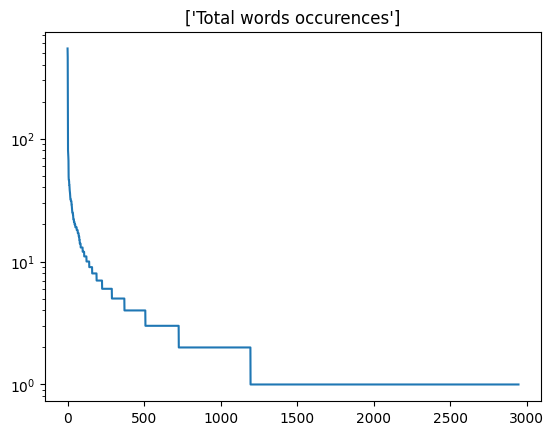

In [ ]:
##### TOTAL DF ######
words, words_dict, documents, Mwd = words_documents_analysis(final_DF_IA_posts)
display_word_occurences(Mwd, 'Total')

In [ ]:
words_dict_no_pos=words_document_analysis_2(words_dict)

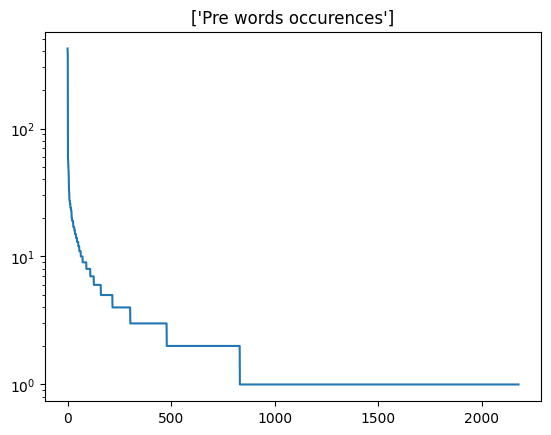

In [ ]:
##### PRE-CHATGPT ####
pre_words, pre_words_dict, pre_documents, pre_Mwd = words_documents_analysis(pre_chatGPT)
display_word_occurences(pre_Mwd, 'Pre')

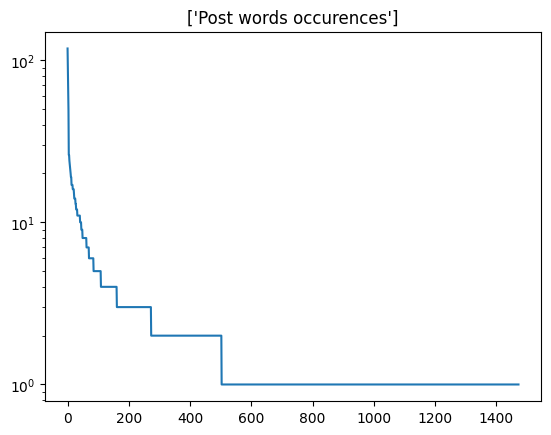

In [ ]:
#### POST-CHATGPT #####
post_words, post_words_dict, post_documents, post_Mwd = words_documents_analysis(post_chatGPT)
display_word_occurences(post_Mwd, 'Post')

We can notice how the trend seems to be the same indipendently from the temporal dimension

In [ ]:
!pip install powerlaw
import powerlaw
from scipy.stats import linregress, kstest

In [ ]:
def plot_degree_distribution(Mwd, title:str, words=True):
  if words:
    ax = 1
    ogg = "words"
  else:
    ax = 0
    ogg = "documents"
  d = np.squeeze(np.asarray(Mwd.sum(axis=ax))) # words degrees
  k = np.unique(d)
  pk = np.histogram(d,np.append(k,k[-1]+1))[0]
  pk = pk/pk.sum()
  Pk = 1-np.cumsum(pk)
  log_k = np.log(k)
  log_pk = np.log(pk)
  slope, intercept, r_value, p_value, std_err = linregress(log_k, log_pk)
  fig = plt.figure()
  plt.loglog(k,pk,'o')
  plt.title(title+" degree distribution for "+ogg, size=16)
  plt.xlabel("k", size=12)
  plt.ylabel("pk", size=12)
  plt.show()
  print("Gamma (slope of the power-law distribution):", -slope)
  fit = powerlaw.Fit(d)

  # Perform the Kolmogorov-Smirnov (KS) test
  result = kstest(d, 'powerlaw', args=(fit.alpha, fit.xmin, fit.sigma))
  #If the p-value is high (typically > 0.05), we might accept the null hypothesis that the data
  #follows a power-law distribution.
  if(result.pvalue > 0.05):
    print("KS test confirm the power law distribution assumption")
  else:
    print("KS test confirm that it's not following the power law distribution assumption ")

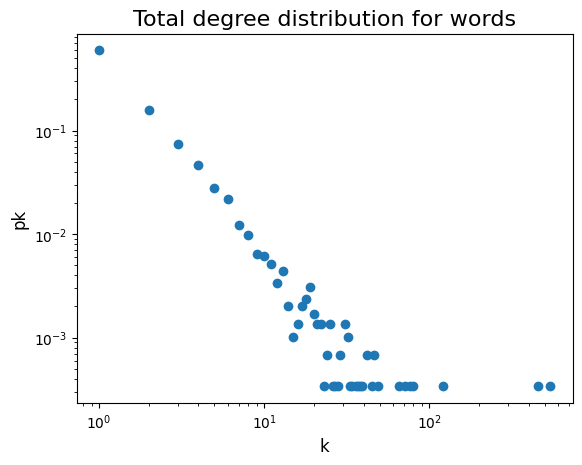

Gamma (slope of the power-law distribution): 1.3827606279988174
Calculating best minimal value for power law fit
KS test confirm that it's not following the power law distribution assumption 


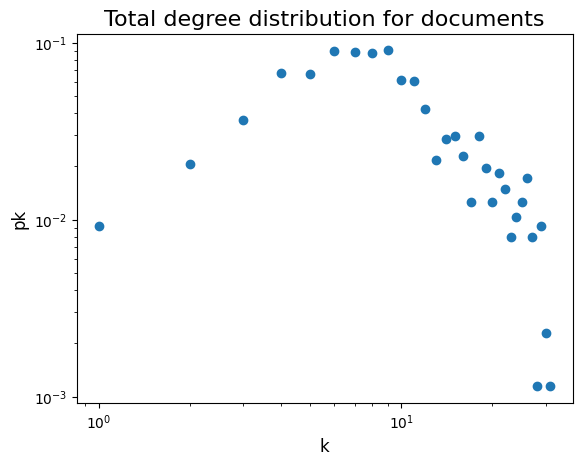

Gamma (slope of the power-law distribution): 0.6797765086352461
Calculating best minimal value for power law fit
KS test confirm that it's not following the power law distribution assumption 


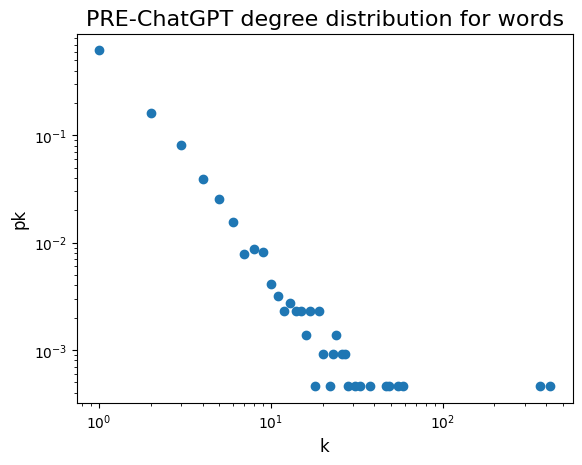

Gamma (slope of the power-law distribution): 1.3395208347593432
Calculating best minimal value for power law fit
KS test confirm that it's not following the power law distribution assumption 


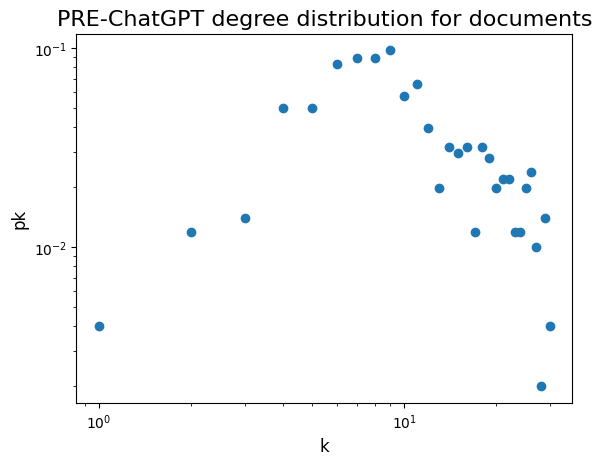

Gamma (slope of the power-law distribution): 0.18393624260867333
Calculating best minimal value for power law fit
KS test confirm that it's not following the power law distribution assumption 


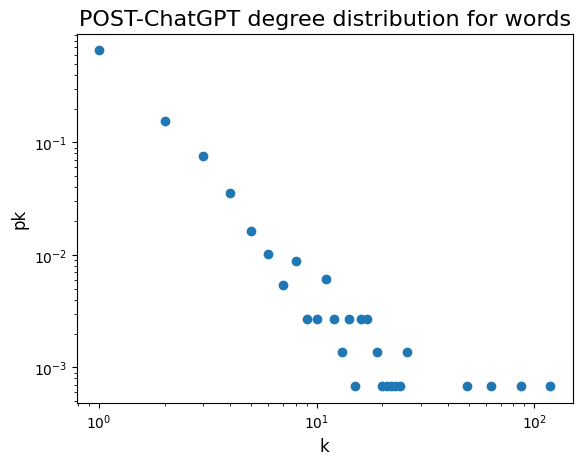

Gamma (slope of the power-law distribution): 1.5504644996471109
Calculating best minimal value for power law fit
KS test confirm that it's not following the power law distribution assumption 


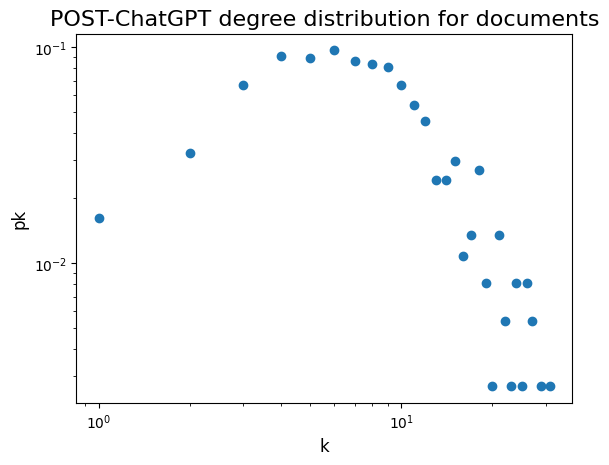

Gamma (slope of the power-law distribution): 0.9643445300130008
Calculating best minimal value for power law fit
KS test confirm that it's not following the power law distribution assumption 


In [ ]:
#Total Mwd
plot_degree_distribution(Mwd, words=True, title="Total")
plot_degree_distribution(Mwd, words=False, title="Total")
#Pre-Mwd
plot_degree_distribution(pre_Mwd, words=True, title="PRE-ChatGPT")
plot_degree_distribution(pre_Mwd, words=False, title="PRE-ChatGPT")
#Post-Mwd
plot_degree_distribution(post_Mwd, words=True, title="POST-ChatGPT")
plot_degree_distribution(post_Mwd, words=False, title="POST-ChatGPT")

In [ ]:
def clean_Mwd_matrix(Mwd, words, documents):
  old_dim = Mwd.shape #memorize it
  print('BEFORE REMOVAL')
  print('Size Matrix Mwd: ', Mwd.shape)

  #Firstly, we remove words that are too central
  not_wanted = np.array(Mwd.sum(axis=1)).flatten()>Mwd.shape[1]/4
  text = "Removing words: " + " ".join(words[not_wanted])
  words = words[~not_wanted]
  Mwd = Mwd[~not_wanted,:]

  #Then we remove words that appear only once or twice (in less than 3 documents)
  not_wanted = np.array(np.sum(Mwd,axis=1)).flatten()<=2
  text = text + " " + " ".join(words[not_wanted])
  words = words[~not_wanted]
  Mwd = Mwd[~not_wanted,:]

  print(text)

  #And documents that cointain no words
  # remove documents with less than 2 words
  wanted = np.array(Mwd.sum(axis=0)).flatten()>1
  Mwd = Mwd[:,wanted]
  print("Removing documents: ", documents[~wanted])
  documents = documents[wanted]
  words_dict = dict(zip(words,range(len(words))))
  print('AFTER REMOVAL')
  print('Size Matrix Mwd: ', Mwd.shape)

  return Mwd, words, documents, words_dict

In [ ]:
print("Matrix Mwd")
Mwd, words, documents, words_dict = clean_Mwd_matrix(Mwd, words, documents)

print("Matrix pre_Mwd")
pre_Mwd, pre_words, pre_documents, pre_words_dict = clean_Mwd_matrix(pre_Mwd, pre_words, pre_documents)

print("Matrix pre_Mwd")
post_Mwd, post_words, post_documents, post_words_dict = clean_Mwd_matrix(post_Mwd, post_words, post_documents)

Matrix Mwd
BEFORE REMOVAL
Size Matrix Mwd:  (2948, 874)
Removing words: artificial ADJ intelligence NOUN abroad ADV absolutely ADV absorb VERB absurd ADJ abuse VERB academic ADJ accept VERB accessibility NOUN accessible ADJ accommodate VERB account NOUN accountability NOUN accurately ADV accuse VERB acidity NOUN act NOUN act VERB action NOUN activist PROPN actor NOUN adam PROPN add VERB administrative ADJ admit VERB adobe NOUN adult NOUN advance VERB advancement NOUN advancement PROPN adventure NOUN advertiser NOUN advice NOUN aerial ADJ afloat VERB africa PROPN african ADJ again ADV agar NOUN ageing NOUN agile ADJ agility NOUN aging NOUN agis NOUN agree VERB ahead ADV ai ADV aia PROPN aid VERB aiforhealth PROPN aim NOUN air NOUN airline NOUN ais NOUN aitx NOUN aitx PROPN alarm NOUN alarmist ADJ albert PROPN alberta PROPN algae NOUN alibaba PROPN alien ADJ alien NOUN align VERB alike ADV alive ADJ all ADV allen VERB allocate VERB alpaca NOUN alphageometry VERB alternative ADJ altman NO

In [ ]:
#Checkpoint: saving the results
#Uncomment if you want to save the results
"""
pickle.dump([Mwd,words,documents], open('drive/MyDrive/Colab Notebooks/ProjectNS/'+"occurrences.p", "wb"))
pickle.dump([pre_Mwd,pre_words,pre_documents], open('drive/MyDrive/Colab Notebooks/ProjectNS/'+"pre_occurrences.p", "wb"))
pickle.dump([post_Mwd,post_words,post_documents], open('drive/MyDrive/Colab Notebooks/ProjectNS/'+"post_occurrences.p", "wb"))
"""

'\npickle.dump([Mwd,words,documents], open(\'drive/MyDrive/Colab Notebooks/ProjectNS/\'+"occurrences.p", "wb"))\npickle.dump([pre_Mwd,pre_words,pre_documents], open(\'drive/MyDrive/Colab Notebooks/ProjectNS/\'+"pre_occurrences.p", "wb"))\npickle.dump([post_Mwd,post_words,post_documents], open(\'drive/MyDrive/Colab Notebooks/ProjectNS/\'+"post_occurrences.p", "wb"))\n'

# **Build Probabilities Matrices from words occurrences**

In [ ]:
def logg(x):

  y = np.log(x)
  y[x==0] = 0

  return y

def probability_matrices(Mwd, equalik = True, tform = False):
  Pw_d = Mwd/(np.sum(Mwd, axis=0).flatten())
  #print(Pw_d.shape)
  if not tform:
    if equalik: # documents equally likely
      pd = (np.ones([Mwd.shape[1],1])*(1/Mwd.shape[1])).flatten()
    else: # documents proportional to their length
      pd = np.sum(Mwd,axis=0)/(np.sum(np.sum(Mwd,axis=0)))
    Pwd = np.matmul(Pw_d, np.diag(pd))
  # TF-IDF format
  if (tform):
    iw = -logg(np.sum(Mwd>0,axis=1).flatten()/Mwd.shape[1])
    Pwd = np.matmul(np.diag(np.array(iw)),Pw_d) # TF-IDF form
    Pwd = Pwd/Pwd.sum() # normalize, treat it as Pwd
  # words and document matrices
  pd = Pwd.sum(axis=0).flatten()
  Pww = np.matmul(np.matmul(Pwd, np.linalg.inv(np.diag(pd))),Pwd.T) #(Pwd/pd)*(Pwd.T)
  pw = Pwd.sum(axis=1).flatten()
  Pdd = np.matmul(np.matmul(Pwd.T, np.linalg.inv(np.diag(pw))),Pwd) #(Pwd.T/pw)*Pwd
  # joint words and document matrix - documents first
  Paa = sps.hstack((sps.csr_matrix((Pwd.shape[1],Pwd.shape[1])),Pwd.T))
  Paa = sps.vstack((Paa,sps.hstack((Pwd,sps.csr_matrix((Pwd.shape[0],Pwd.shape[0]))))))
  Paa = Paa/2.0

  return Pwd, Pww, Pdd, Paa

In [ ]:
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd)
pre_Pwd, pre_Pww, pre_Pdd, pre_Paa = probability_matrices(pre_Mwd)
post_Pwd, post_Pww, post_Pdd, post_Paa = probability_matrices(post_Mwd)

# **Graph Creation using Networkx Library**

In [ ]:
!pip install networkx
import networkx as nx

In [ ]:
def graph_generation1(df):
  graph = nx.Graph() #Il Bipartite Graph documents-words
  graph.add_nodes_from(df['id'], bipartite=0) #prima partizione
  for word_list in df['text_deep_clean']:
    word_list = word_list.split()
    graph.add_nodes_from(word_list, bipartite=1) #seconda partizione

  for row in df.itertuples(index=False):
    word_list = row.text_deep_clean
    word_list = word_list.split()
    graph.add_edges_from([(row.id, word) for word in word_list]) #qui sta creando un collegamento tra il documento e tutte le parole che contiene

  #Ma, noi vogliamo il network proiettato sulle words (quindi edges tra word appartenenti al medesimo documento)
  nodes_set1 = set(word for word_list in df['text_deep_clean'] for word in word_list.split())
  nodes_set2 = set(doc for doc in df['id'])
  graph_ww = nx.bipartite.projected_graph(graph, nodes=nodes_set1)
  graph_dd = nx.bipartite.projected_graph(graph, nodes_set2)

  return graph, graph_ww, graph_dd

In [ ]:
#Ma, se invece sfruttiamo il fatto di avere già words e documents (con un'ulteriore pulizia che ha eliminato le parole non interessanti)
def graph_generation2(Mwd, words, documents, words_dict):
  Gwd = nx.Graph() #Il Bipartite Graph documents-words
  Gwd.add_nodes_from(documents, bipartite=0) #prima partizione
  Gwd.add_nodes_from([word_pos.split()[0] for word_pos in words], bipartite=1) #già la abbiamo la lista di parole

  for doc_index in range(len(documents)):
    doc = documents[doc_index]
    Gwd.add_edges_from([doc, words[word_index].split()[0]] for word_index in np.where(Mwd[:,doc_index]>0)[0])

  nodes_set1 = [word.split()[0] for word in words]
  nodes_set2 = documents
  Gww = nx.bipartite.projected_graph(Gwd, nodes=nodes_set1)
  Gdd = nx.bipartite.projected_graph(Gwd, nodes=nodes_set2)
  return Gwd, Gww, Gdd

In [ ]:
import csv

def export_graph_to_csv(G, nodes_filename, edges_filename):

    # Generate numerical IDs for nodes
    node_id_map = {node: idx for idx, node in enumerate(G.nodes(), start=1)}

    # Write nodes to CSV file
    with open(nodes_filename, 'w', newline='') as nodes_file:
        writer = csv.writer(nodes_file)
        writer.writerow(['Node ID', 'Label'])  # Write header
        for node, node_id in node_id_map.items():
            writer.writerow([node_id, node])

    # Write edges to CSV file
    with open(edges_filename, 'w', newline='') as edges_file:
        writer = csv.writer(edges_file)
        writer.writerow(['Source', 'Target'])  # Write header
        for edge in G.edges():
            source_id = node_id_map[edge[0]]
            target_id = node_id_map[edge[1]]
            writer.writerow([source_id, target_id])


In [ ]:
#Metodo 1
pre_Gwd1, pre_Gww1, pre_Gdd1 = graph_generation1(pre_chatGPT)
post_Gwd1, post_Gww1, post_Gdd1 = graph_generation1(post_chatGPT)

#Metodo 2
pre_Gwd2, pre_Gww2, pre_Gdd2 = graph_generation2(pre_Mwd, pre_words, pre_documents, pre_words_dict)
post_Gwd2, post_Gww2, post_Gdd2 = graph_generation2(post_Mwd, post_words, post_documents, post_words_dict)

In [ ]:
METODO = 2 #1
if METODO == 1:
  pre_G = pre_Gww1
  post_G = post_Gww1
else:
  pre_G = pre_Gww2
  post_G = post_Gww2

pre_g = ig.Graph.from_networkx(pre_G)
post_g = ig.Graph.from_networkx(post_G)

In [ ]:
export_graph_to_csv(pre_Gww2, 'nodes_pre_Gww2.csv', 'edges_pre_Gww2.csv')

In [ ]:
export_graph_to_csv(post_Gww2, 'nodes_post_Gww2.csv', 'edges_post_Gww2.csv')

# **Centrality Measures**

**ADJACENCY MATRICES**

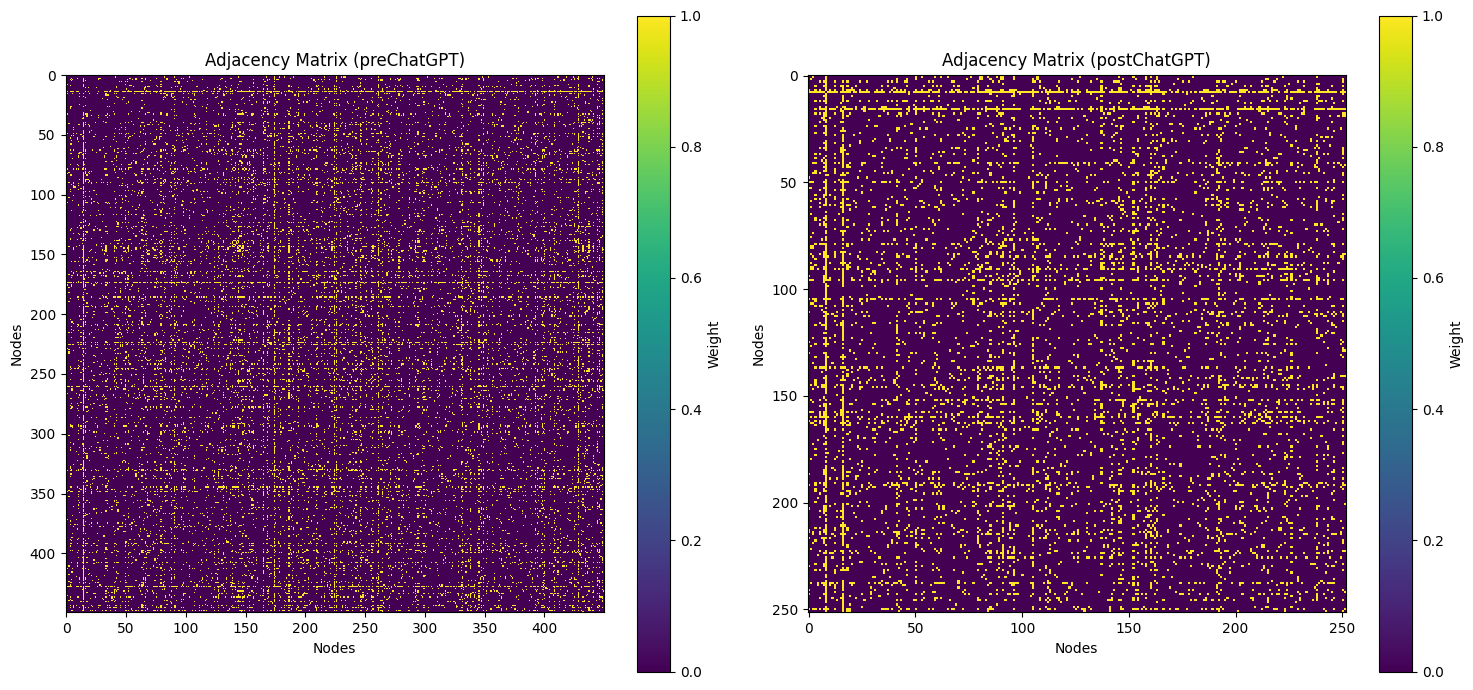

In [ ]:

# Get adjacency matrix (as a list of lists)
adj_matrix_pre = pre_g.get_adjacency()

# Convert list of lists to numpy array for plotting
adj_matrix_np_pre = np.array(adj_matrix_pre.data)

# Slice the array to get the first 50 submatrix
adj_matrix_np_sub_pre = adj_matrix_np_pre


# Get adjacency matrix (as a list of lists)
adj_matrix_post = post_g.get_adjacency()

# Convert list of lists to numpy array for plotting
adj_matrix_np_post = np.array(adj_matrix_post.data)

# Slice the array to get the first 50 submatrix
adj_matrix_np_sub_post = adj_matrix_np_post

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot for adj_matrix_np_sub_pre
im1 = axs[0].imshow(adj_matrix_np_sub_pre, cmap='viridis', interpolation='nearest')
axs[0].set_title('Adjacency Matrix (preChatGPT)')
axs[0].set_xlabel('Nodes')
axs[0].set_ylabel('Nodes')
axs[0].grid(False)
fig.colorbar(im1, ax=axs[0], label='Weight')

# Plot for adj_matrix_np_sub_post
im2 = axs[1].imshow(adj_matrix_np_sub_post, cmap='viridis', interpolation='nearest')
axs[1].set_title('Adjacency Matrix (postChatGPT)')
axs[1].set_xlabel('Nodes')
axs[1].set_ylabel('Nodes')
axs[1].grid(False)
fig.colorbar(im2, ax=axs[1], label='Weight')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
print("Pre CHATGPT. Is the graph connected:","yes" if pre_g.is_connected() else "no")
print("Post CHATGPT. Is the graph connected:","yes" if post_g.is_connected() else "no")

Pre CHATGPT. Is the graph connected: yes
Post CHATGPT. Is the graph connected: yes


## PageRank

In [ ]:
pre_pagerank_scores = nx.pagerank(pre_G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)
post_pagerank_scores = nx.pagerank(post_G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

WordCloud

In [ ]:
from wordcloud import WordCloud
from PIL import Image
def wordcloud_fun(pre_pagerank_scores):
  # Create a higher resolution circular mask
  x, y = np.ogrid[:1000, :1000]
  mask = (x - 500) ** 2 + (y - 500) ** 2 > 400 ** 2
  mask = 255 * mask.astype(int)

  pre_pagerank_scores = {key: float(value) for key, value in pre_pagerank_scores.items()}

  # Define a custom color function
  def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
      return f"hsl({np.random.randint(0, 360)}, 100%, {np.random.randint(25, 75)}%)"

  wordcloud_pre = WordCloud(
      mask=mask,
      background_color="white",
      color_func=color_func,
      prefer_horizontal=1.0,  # Ensure words are not rotated
      random_state=42
  )
  # Use generate_from_frequencies with font size proportional to PageRank scores
  wordcloud_pre.generate_from_frequencies(pre_pagerank_scores)
  image_data = wordcloud_pre.to_array()

  return image_data

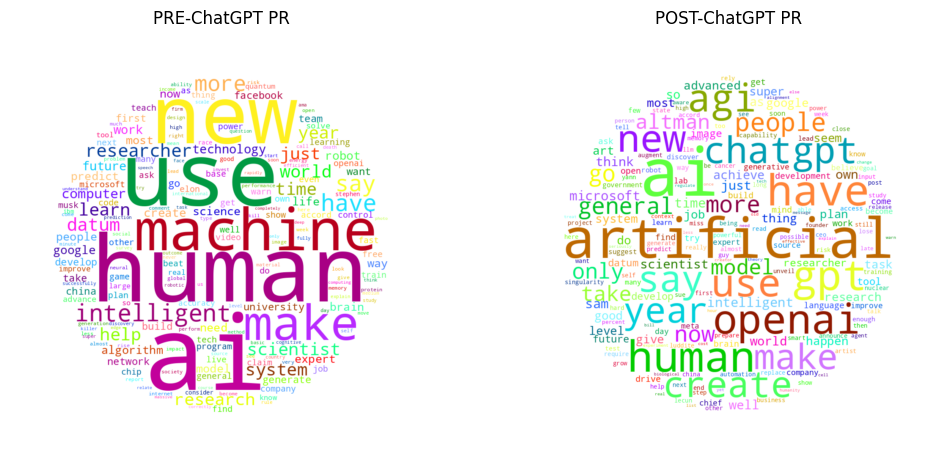

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot word clouds on the subplots
ax1.imshow(wordcloud_fun(pre_pagerank_scores), interpolation="bilinear")
ax1.set_title('PRE-ChatGPT PR')
ax1.axis("off")

ax2.imshow(wordcloud_fun(post_pagerank_scores), interpolation="bilinear")
ax2.set_title('POST-ChatGPT PR')
ax2.axis("off")

# Show the plots
plt.show()

## Degree-Closeness-Betweenees-Harmonic Centrality

In [ ]:
pre_degree_centrality = nx.degree_centrality(pre_G)
post_degree_centrality = nx.degree_centrality(post_G)

pre_closness=nx.closeness_centrality(pre_G)
post_closness=nx.closeness_centrality(post_G)

pre_beweenness_centrality=nx.betweenness_centrality(pre_G)
post_beweenness_centrality=nx.betweenness_centrality(post_G)

pre_eigenv=nx.eigenvector_centrality(pre_G)
post_eigenv=nx.eigenvector_centrality(post_G)

pre_harmonic=nx.harmonic_centrality(pre_G)
post_harmonic=nx.harmonic_centrality(post_G)

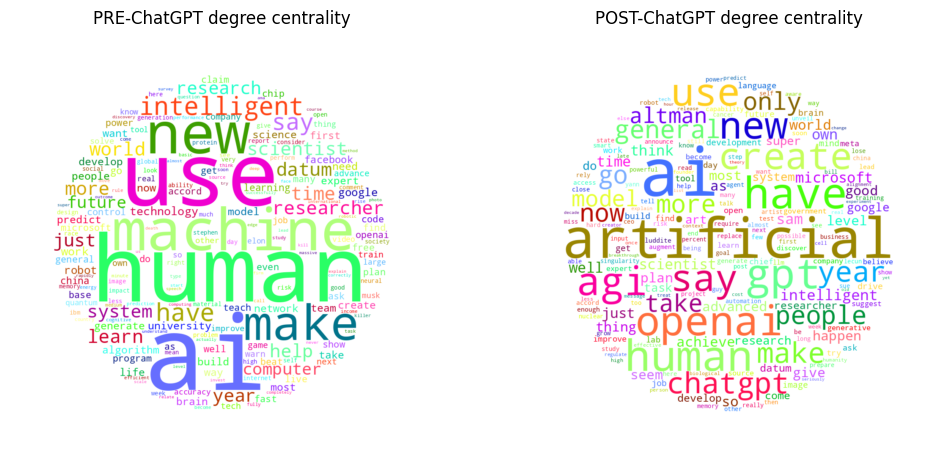

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot word clouds on the subplots
ax1.imshow(wordcloud_fun(pre_degree_centrality), interpolation="bilinear")
ax1.set_title('PRE-ChatGPT degree centrality')
ax1.axis("off")

ax2.imshow(wordcloud_fun(post_degree_centrality), interpolation="bilinear")
ax2.set_title('POST-ChatGPT degree centrality')
ax2.axis("off")

# Show the plots
plt.show()

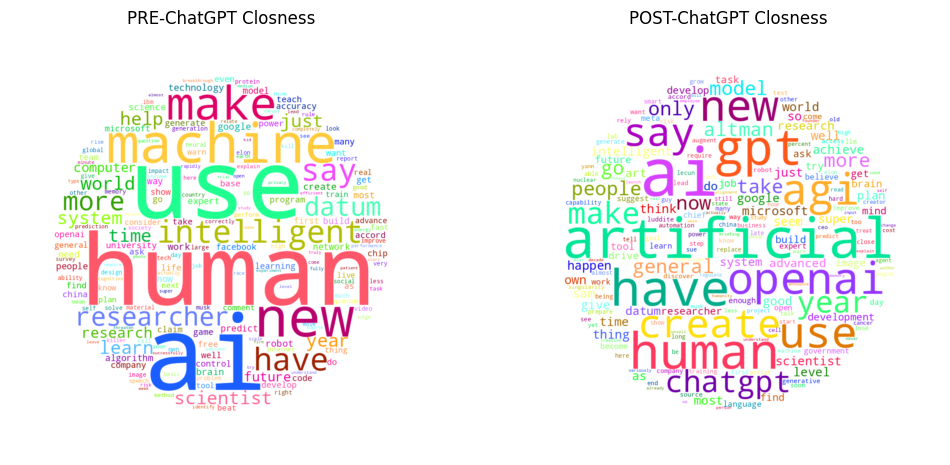

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot word clouds on the subplots
ax1.imshow(wordcloud_fun(pre_closness), interpolation="bilinear")
ax1.set_title('PRE-ChatGPT Closness')
ax1.axis("off")

ax2.imshow(wordcloud_fun(post_closness), interpolation="bilinear")
ax2.set_title('POST-ChatGPT Closness')
ax2.axis("off")

# Show the plots
plt.show()

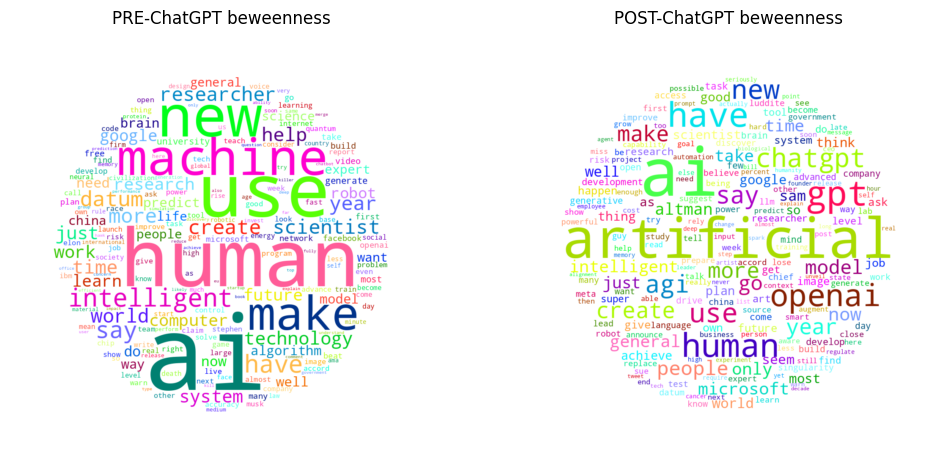

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot word clouds on the subplots
ax1.imshow(wordcloud_fun(pre_beweenness_centrality), interpolation="bilinear")
ax1.set_title('PRE-ChatGPT beweenness')
ax1.axis("off")

ax2.imshow(wordcloud_fun(post_beweenness_centrality), interpolation="bilinear")
ax2.set_title('POST-ChatGPT beweenness')
ax2.axis("off")

# Show the plots
plt.show()

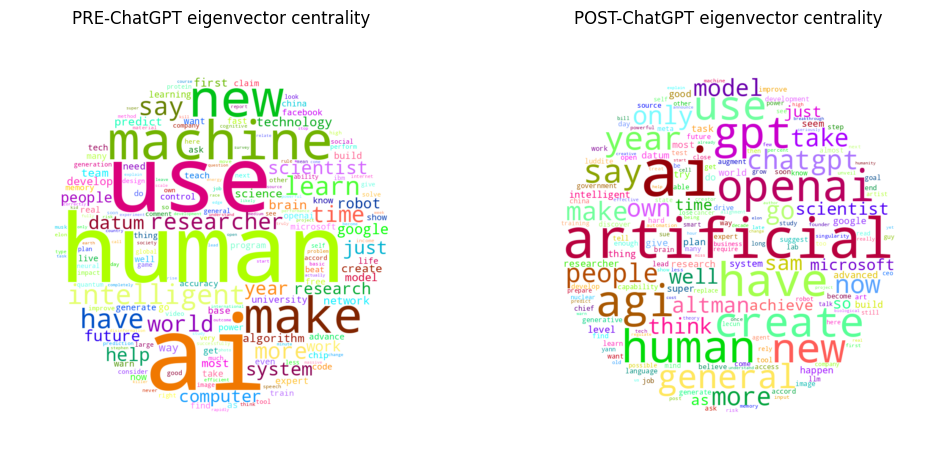

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot word clouds on the subplots
ax1.imshow(wordcloud_fun(pre_eigenv), interpolation="bilinear")
ax1.set_title('PRE-ChatGPT eigenvector centrality')
ax1.axis("off")

ax2.imshow(wordcloud_fun(post_eigenv), interpolation="bilinear")
ax2.set_title('POST-ChatGPT eigenvector centrality')
ax2.axis("off")

# Show the plots
plt.show()

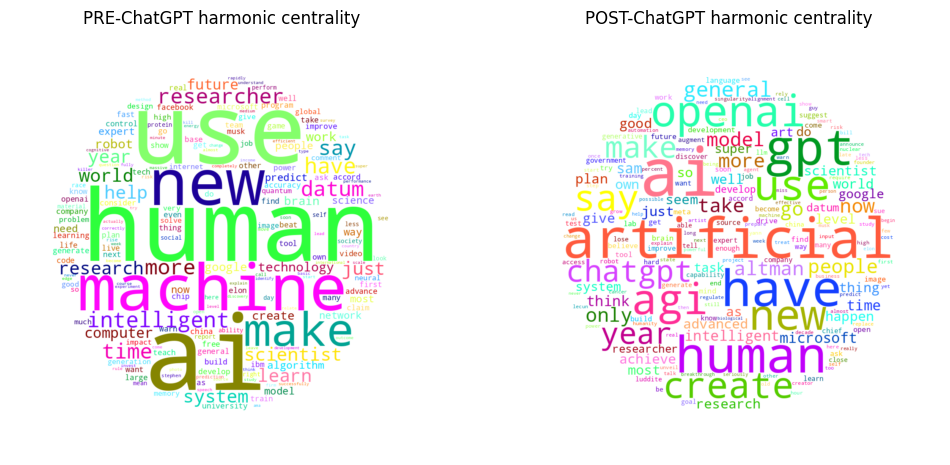

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot word clouds on the subplots
ax1.imshow(wordcloud_fun(pre_harmonic), interpolation="bilinear")
ax1.set_title('PRE-ChatGPT harmonic centrality')
ax1.axis("off")

ax2.imshow(wordcloud_fun(post_harmonic), interpolation="bilinear")
ax2.set_title('POST-ChatGPT harmonic centrality')
ax2.axis("off")

# Show the plots
plt.show()

## Clustering Coefficient

In [ ]:
def clusteringCoeff(g_prop):
    # Global clustering coefficient
    global_clustering_coefficient = g_prop.transitivity_undirected()

    #print('Global clustering coefficient:', global_clustering_coefficient)

    # Calculate the local clustering coefficient for each node
    local_clustering_coefficients = g_prop.transitivity_local_undirected(mode='zero')

    # Pair each coefficient with the corresponding node label
    local_clustering_dict = {g_prop.vs[i]['_nx_name']: coeff for i, coeff in enumerate(local_clustering_coefficients)}

    #Print the dictionary
    #for label, coeff in local_clustering_dict.items():
       #print(f"Node {label}: Local clustering coefficient = {coeff}")

    # Average clustering coefficient
    average_clustering_coefficient = sum(local_clustering_coefficients) / len(local_clustering_coefficients)
    return global_clustering_coefficient, average_clustering_coefficient

pre_global_clustering_coefficient, pre_average_clustering_coefficient = clusteringCoeff(pre_g)
post_global_clustering_coefficient, post_average_clustering_coefficient= clusteringCoeff(post_g)
print('Global clustering coefficient preChatGPT:', pre_global_clustering_coefficient),
print('Average clustering coefficient preChatGPT:', pre_average_clustering_coefficient),
print('Global clustering coefficient postChatGPT:', post_global_clustering_coefficient),
print('Average clustering coefficient postChatGPT:', post_average_clustering_coefficient)

Global clustering coefficient preChatGPT: 0.28181619495137145
Average clustering coefficient preChatGPT: 0.4814329116399218
Global clustering coefficient postChatGPT: 0.3030241705981306
Average clustering coefficient postChatGPT: 0.5163646150859601


# **Topic Detection (Community Assignment)**

# COMMUNITY DETECTION ALGORITHMS

###**MODULARITY**

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
# It starts with each node as a separate community and iteratively merges communities that lead to the greatest increase
#in modularity.

communities_pre = greedy_modularity_communities(pre_G)

# Print the detected communities
for i, community in enumerate(communities_pre):
    print(f"Community {i+1}: {list(community)}")

communities_post = greedy_modularity_communities(post_G)

# Print the detected communities
for i, community in enumerate(communities_post):
    print(f"Community {i+1}: {list(community)}")

Community 1: ['open', 'same', 'quantum', 'physics', 'mit', 'neuron', 'boost', 'unveil', 'tech', 'engine', 'stop', 'child', 'machine', 'structure', 'take', 'solar', 'disease', 'thing', 'recognize', 'manufacturing', 'rich', 'just', 'such', 'team', 'apply', 'first', 'scientist', 'flow', 'lead', 'invest', 'show', 'international', 'space', 'intel', 'term', 'nature', 'researcher', 'protein', 'control', 'task', 'know', 'player', 'synapsis', 'massive', 'artifical', 'study', 'programming', 'ibm', 'generate', 'accurate', 'ultra', 'announce', 'ask', 'generation', 'relate', 'image', 'song', 'pilot', 'accuracy', 'learning', 'scale', 'useful', 'resource', 'computing', 'help', 'many', 'tactical', 'base', 'prediction', 'algorithm', 'fake', 'game', 'brain', 'performance', 'drug', 'university', 'photo', 'get', 'well', 'train', 'learn', 'very', 'real', 'neural', 'chip', 'become', 'only', 'create', 'code', 'time', 'own', 'here', 'soon', 'beat', 'social', 'group', 'compute', 'equation', 'large', 'film', 't

In [ ]:
def list_to_C(communities, words, word_dict):
  words_dict_no_pos=words_document_analysis_2(word_dict)
  C = np.zeros([len(words), len(communities)])
  i=-1
  for community in communities:
    i+=1
    for word in community: C[words_dict_no_pos[word], i] = 1
  return C

###**LOUVAIN**

In [ ]:
louvain_clusters = pre_g.community_multilevel()
louvain_membership_pre = louvain_clusters.membership

# Map the memberships back to node labels
louvain_communities_pre = {pre_g.vs[i]['_nx_name']: membership for i, membership in enumerate(louvain_membership_pre)}
print(louvain_communities_pre)
# Number of communities for the Louvain method
num_communities_louvain_pre = max(louvain_membership_pre) + 1
print(f'Number of communities (Louvain) in preChatGPT: {num_communities_louvain_pre}')

louvain_clusters = post_g.community_multilevel()
louvain_membership = louvain_clusters.membership
# Map the memberships back to node labels
louvain_communities_post = {post_g.vs[i]['_nx_name']: membership for i, membership in enumerate(louvain_membership)}
print(louvain_communities_post)
# Number of communities for the Louvain method
num_communities_louvain_post = max(louvain_membership) + 1
print(f'Number of communities (Louvain) in postChatGPT: {num_communities_louvain_post}')

{'ability': 0, 'able': 0, 'accelerate': 1, 'accord': 2, 'accuracy': 3, 'accurate': 3, 'achieve': 2, 'acquire': 2, 'activity': 0, 'actually': 3, 'advance': 4, 'advanced': 0, 'age': 5, 'agi': 5, 'ai': 4, 'aitx': 2, 'algorithm': 0, 'almost': 6, 'alphago': 4, 'also': 0, 'altman': 7, 'ama': 5, 'america': 1, 'analyze': 8, 'animal': 0, 'announce': 5, 'apply': 0, 'approach': 0, 'arm': 2, 'artifical': 5, 'artificial': 7, 'artificially': 2, 'artist': 7, 'as': 8, 'ask': 5, 'astoundingly': 6, 'author': 3, 'available': 1, 'away': 1, 'ban': 2, 'base': 0, 'basic': 1, 'beat': 8, 'become': 5, 'believe': 2, 'benefit': 1, 'biological': 2, 'book': 5, 'boost': 8, 'brain': 0, 'break': 0, 'breakthrough': 3, 'build': 5, 'business': 2, 'call': 2, 'cancer': 3, 'capable': 8, 'car': 0, 'case': 8, 'cat': 2, 'change': 1, 'chatbot': 3, 'child': 8, 'china': 2, 'chip': 2, 'civilization': 2, 'claim': 0, 'close': 5, 'code': 7, 'coder': 7, 'cognitive': 0, 'collapse': 2, 'combat': 8, 'come': 8, 'comment': 8, 'company': 2,

In [ ]:
def dict_to_matrix(dizio, num_communities, word_dict):
  C=np.zeros([len(word_dict), num_communities])
  words_dict_no_pos=words_document_analysis_2(word_dict)
  for word in dizio.keys():
    C[words_dict_no_pos[word], dizio[word] ] = 1
  return C

###**SOFT LOUVAIN**

In [ ]:
def soft_assign(a,v):
  if (a>=0):
    u = np.array(v.data)
    n = np.where(u==u.max())[0][0]
    u = np.zeros(u.shape)
    u[n] = 1
    return np.array(u)/u.sum()
  else:
    u = -np.array(v.data)/a
    g = np.sort(u)[::-1]
    z = np.cumsum(g)-np.append(np.array(range(1,len(g)))*g[1:len(g)],-np.Inf)
    n = np.where(z>=1)[0][0]
    la = ((g[0:n+1]).sum()-1)/(n+1)
    u = u-la
    u[u<0] = 0
    return np.array(u)/u.sum()

def modularity_function(A):
    y = A.trace()-(A.sum(axis=0)*A.sum(axis=1)).item()
    return y

def _my_one_level(A,C):

    N = A.shape[0] # number of nodes
    rand_nodes = list(range(N)) # random nodes list
    shuffle(rand_nodes) # shuffle random nodes list

    d_in = np.transpose(A.sum(axis=1)) # input degrees - row vector
    d_out = A.sum(axis=0) # output degrees - row vector
    A = A + A.T # sum easily accessible by row

    # main loop - loop until you do not see any improvement
    improvement = False
    while True:

        # counter for the number of nodes changing community
        nb_moves = 0
        # test each node
        for i in rand_nodes:
            # get the community of node i
            ci_old = C[i,0:C.shape[1]].toarray()[0]
            # modify C for our purposes, i.e., exclude node i
            C[i,0:C.shape[1]] = 0
            # build vector v for evaluating modularity increase
            v = (A[i]-d_out[0,i]*d_in-d_in[0,i]*d_out)/2
            # find the maximum - best community
            ci = soft_assign(v[0,i],np.array(v*C)[0])
            # update matrix
            C[i,0:C.shape[1]] = ci
            # update counter (if needed)
            nb_moves += np.linalg.norm(ci-ci_old)
        #print("Moves: ")
        #print(nb_moves)
        # exit if no improvement
        if (nb_moves<1e-10): break
        # otherwise: remove empty communities
        C = C[:,np.unique(scipy.sparse.find(C)[1])]
        # set improvement and reshuffle nodes for next try
        improvement = True
        shuffle(rand_nodes)

    # exit
    return C, improvement

from random import shuffle

def my_soft_louvain(A, C_start=None, seed=None):
    """
    Find the best partition of a graph using the Louvain Community Detection
    Algorithm.

    References
    [1] Blondel, V.D. et al. Fast unfolding of communities in large networks.
        J. Stat. Mech 10008, 1-12(2008).
        https://doi.org/10.1088/1742-5468/2008/10/P10008
    [2] Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden:
        guaranteeing well-connected communities. Sci Rep 9, 5233 (2019).
        https://doi.org/10.1038/s41598-019-41695-z
    [3] Nicolas Dugué, Anthony Perez. Directed Louvain : maximizing modularity
        in directed networks. [Research Report] Université d’Orléans. 2015.
        hal-01231784. https://hal.archives-ouvertes.fr/hal-01231784
    """

    # initialize random seed
    np.random.seed(seed)
    # normalize matrix - otherwise it doesn't work -  read by rows
    A = sps.csr_matrix(A)/A.sum()
    # initialize the community assignment matrix to "each node is a community"
    C = sps.csr_matrix(sps.identity(A.shape[0], dtype='float'))
    # starting assignment
    if (C_start==None):
      C_start = sps.csr_matrix(sps.identity(A.shape[0], dtype='float'))

    # main loop for the different layers of Louvain
    while True:
        #print([C.shape[0], C.shape[1]])
        # improve modularity in this layer
        Clayer, improvement = _my_one_level(A,C_start)
        # exit if no improvement
        if (improvement==False): break
        # otherwise update variables according to the new clusters
        C = C*Clayer
        A = Clayer.T*(A*Clayer)
        # initialize the community assignment matrix to "each node is a community"
        C_start = sps.csr_matrix(sps.identity(A.shape[0], dtype='float'))

    #print("CONVERGENCE REACHED! NO MORE IMPROVEMENTS!")

    # return community assignments and resulting adjacency matrix
    Q = modularity_function(A)
    return C, A, Q


###**INFOMAP**

In [ ]:
infomap_clusters_pre = pre_g.community_infomap()
infomap_membership_pre = infomap_clusters_pre.membership

# Map the memberships back to node labels
infomap_communities_pre = {pre_g.vs[i]['_nx_name']: membership for i, membership in enumerate(infomap_membership_pre)}
print(infomap_communities_pre)
# Number of communities for the Infomap method
num_communities_infomap_pre = max(infomap_membership_pre) + 1
print(f'Number of communities preChatGPT (Infomap): {num_communities_infomap_pre}')

infomap_clusters_post = post_g.community_infomap()
infomap_membership_post = infomap_clusters_post.membership

# Map the memberships back to node labels
infomap_communities_post = {post_g.vs[i]['_nx_name']: membership for i, membership in enumerate(infomap_membership_post)}
print(infomap_communities_post)
# Number of communities for the Infomap method
num_communities_infomap_post = max(infomap_membership_post) + 1
print(f'Number of communities postChatGPT (Infomap): {num_communities_infomap_post}')

{'ability': 0, 'able': 0, 'accelerate': 0, 'accord': 0, 'accuracy': 0, 'accurate': 0, 'achieve': 0, 'acquire': 0, 'activity': 0, 'actually': 0, 'advance': 0, 'advanced': 0, 'age': 0, 'agi': 0, 'ai': 0, 'aitx': 0, 'algorithm': 0, 'almost': 1, 'alphago': 0, 'also': 0, 'altman': 0, 'ama': 0, 'america': 0, 'analyze': 0, 'animal': 0, 'announce': 0, 'apply': 0, 'approach': 0, 'arm': 0, 'artifical': 0, 'artificial': 0, 'artificially': 0, 'artist': 0, 'as': 0, 'ask': 0, 'astoundingly': 1, 'author': 0, 'available': 0, 'away': 0, 'ban': 0, 'base': 0, 'basic': 0, 'beat': 0, 'become': 0, 'believe': 0, 'benefit': 0, 'biological': 0, 'book': 0, 'boost': 0, 'brain': 0, 'break': 0, 'breakthrough': 0, 'build': 0, 'business': 0, 'call': 0, 'cancer': 0, 'capable': 0, 'car': 0, 'case': 0, 'cat': 0, 'change': 0, 'chatbot': 0, 'child': 0, 'china': 0, 'chip': 0, 'civilization': 0, 'claim': 0, 'close': 0, 'code': 0, 'coder': 0, 'cognitive': 0, 'collapse': 0, 'combat': 0, 'come': 0, 'comment': 0, 'company': 0,

### **BerTOPIC**

In [ ]:
import copy

# function to map the topis into a community assignment matrix C
# where rows represent documents, and columns represent topics
def topics_to_C(topics):

  # extract community assignments
  C = sps.csr_matrix((len(topics),max(topics)+2))
  for i in range(C.shape[1]):
    C[np.array(topics)==(i-1),i] = 1

  # remove zero assignments
  C = C[:,np.unique(scipy.sparse.find(C)[1])]

  return C

def plot_community_patterns(C,nrows,ncols,refs):

  fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                          figsize=(20*nrows, 20*ncols),
                          subplot_kw={'xticks': [], 'yticks': []})

  for i in range(len(C)):
    # identify an order for rankings based on refs
    if ((i%ncols)==0):
      tmp0 = C[refs[0]+i]
      tmp0 = np.array([tmp0[i].argmax()+1 for i in range(tmp0.shape[0])])
      tmp1 = C[refs[1]+i]
      tmp1 = np.array([tmp1[i].argmax()+1 for i in range(tmp1.shape[0])])
      pos = np.argsort(tmp0+(tmp1/tmp1.max())/2)

    # plot matrices
    tmp = sps.csr_matrix(C[i]).astype(np.float32)
    tmp = tmp[pos,] # reorder
    M = tmp*(tmp.T)
    ax = axs.flat[i]
    ax.imshow(M.toarray(), cmap='viridis')


print('bertopic 1.11')

def bertopic_overwrite(bert_model_in,docs,C):
  bert_model = copy.deepcopy(bert_model_in)

  # build the documents dataframe: 'Document' + "Topic"
  documents = pd.DataFrame(docs,columns=['Document'])
  tmp = np.array([C[i].argmax() for i in range(C.shape[0])])
  documents["Topic"] = tmp

  # update topic assignment
  bert_model.topics_ = tmp.tolist()

  # build cf-idf values
  documents_per_topic = documents.groupby(['Topic'],
                    as_index=False).agg({'Document': ' '.join})
  c_tf_idf_, words = bert_model._c_tf_idf(documents_per_topic)
  bert_model.c_tf_idf_ = c_tf_idf_

  # extract words representations
  topic_representations_ = bert_model._extract_words_per_topic(words, documents)
  bert_model.topic_representations_ = topic_representations_
  bert_model.topic_labels_ = {key: f"{key}_" + "_".join([word[0] for word in values[:4]])
                              for key, values in
                              topic_representations_.items()}

  # exit
  return bert_model

bertopic 1.11


In [ ]:
# start a time counter
tic_post = time.time()

# prepare a BERTopic instance
bert_model_post = BERTopic()

# run BERTopic
docs_post=post_words
topics_post, probabilities_post = bert_model_post.fit_transform(docs_post)

# map the topics into a community assignment matrix C
C_b_post = topics_to_C(topics_post)
C_b_post= C_b_post.toarray()
# capture execution time
et_bert_post = time.time()-tic_post

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
# start a time counter
tic_pre = time.time()

# prepare a BERTopic instance
bert_model_pre = BERTopic()

# run BERTopic
docs_pre=pre_words
topics_pre, probabilities_pre = bert_model_pre.fit_transform(docs_pre)

# map the topics into a community assignment matrix C
#This matrix represents the assignment of documents to different communities or topics.
# Each row in the matrix corresponds to a document, and each column represents a community or topic.
C_b_pre = topics_to_C(topics_pre)
C_b_pre= C_b_pre.toarray()
# capture execution time
et_bert_pre = time.time()-tic_pre

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# EVALUATION METRICS

In [ ]:
def nmi_function(A):
    aw = A.sum(axis=1).flatten()  # word probability
    ac = A.sum(axis=0).flatten()  # class probability

    # Avoid division by zero or log(0)
    ac[ac == 0] = 1e-15  # Small positive value instead of zero
    aw[aw == 0] = 1e-15

    Hc = np.multiply(ac, -np.log(ac)).sum()  # class entropy

    A2 = ((A / ac).T / aw).T
    A2.data = logg(A2.data)

    # Avoid multiplication with NaN or Inf
    A2[np.isnan(A2)] = 0
    A2[np.isinf(A2)] = 0

    y = (A.T @ A2).sum() / Hc
    return y

    #  MODULARITY
def modularity_function(Pcc):

  #A: normalized adjacency matric (Pww or Pdd)
  #C: community assignment matrix (binary, one active entry per column)
  #Pcc = C A C.T : probability matrix linking communities (num of links between communities)
  #Pcc = np.matmul(np.matmul(A, C), C.T)
  #Q = trace(Pcc - pc*pc.T)
  #pc è Pcc * 1 == somma sulle righe
  pc = np.sum(Pcc, axis=0)
  pc_2d = pc.reshape(-1, 1)
  #Q = Pcc.trace() - (np.matmul(pc, pc.T)).trace()
  Q = Pcc.trace() - np.trace(np.matmul(pc_2d, pc_2d.T))
  return Q

def ncut_function(A):
    y = ((A.sum(axis=0)-A.diagonal())/A.sum(axis=0)).mean()
    return y

def my_pagerank(M,q,c=.85,it=60):
    r = q.copy() # ranking matrix, initialized to q (copy)
    for k in range(it): # slow cycle
      r = c*M.dot(r) + (1-c)*q
    return r

def infomap_function(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y

def infomap_rank(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    # pagerank vector - faster than r = my_pagerank(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T

    return r

def clustering_statistics(C,Pwd,Pww,r):
    Pwc = np.matmul(Pwd.T, C) # joint word + class probability
    NMI = nmi_function(Pwc)
    Pcc = np.matmul(C.T, np.matmul(Pww, C)) # joint class + class probability
    Q = modularity_function(Pcc)
    Ncut = ncut_function(Pcc)

    return [NMI, Q, Ncut]

# **Analysis**


##**PRE CHAT GPT**

In [ ]:
#MODULARITY
#Results already stored in communities_pre
hard_Louv_C_pre=list_to_C(communities_pre, pre_words, pre_words_dict)

#LOUVAIN
#Results already stored in louvain_communities_pre

Louv_C_pre=dict_to_matrix(louvain_communities_pre, num_communities_louvain_pre, pre_words_dict)

#SOFT LOUVAIN
adj_matrix_pr1= np.array(adj_matrix_pre.data)
adj_matrix_pr1 = sps.csr_matrix(adj_matrix_pr1)
C_soft_louvain_communities_pre, A_final_pre, modularity_pre= my_soft_louvain(pre_Pww)
C_soft_louvain_communities_pre=C_soft_louvain_communities_pre.toarray()
#Results stored in soft_louvain_communities_pre

#INFOMAP
#Results stored in infomap_communities_pre
infomap_C_pre=dict_to_matrix(infomap_communities_pre, num_communities_infomap_pre, pre_words_dict)
#BERTOPICS
#C_b_pre

##**POST CHAT GPT**

In [ ]:
#MODULARITY
#Results already stored in communities_post
hard_Louv_C_post=list_to_C(communities_post, post_words, post_words_dict)
#LOUVAIN
#Results already stored in louvain_communities_post
Louv_C_post=dict_to_matrix(louvain_communities_post, num_communities_louvain_post, post_words_dict)

#SOFT LOUVAIN
adj_matrix_post1= np.array(adj_matrix_post.data)
adj_matrix_post1 = sps.csr_matrix(adj_matrix_post1)
#C_soft_louvain_communities_post, A_final_post, modularity_post= my_soft_louvain(adj_matrix_post1)
C_soft_louvain_communities_post, A_final_post, modularity_post= my_soft_louvain(post_Pww)
C_soft_louvain_communities_post=C_soft_louvain_communities_post.toarray()
#Results stored in soft_louvain_communities_post

#INFOMAP
#Results stored in infomap_communities_post
infomap_C_post=dict_to_matrix(infomap_communities_post, num_communities_infomap_post, post_words_dict)
#BERTOPICS
#C_b_post

# **RESULTS COMPARISON**

In [ ]:
#Prepare a template dataframe for collecting the results
df_results_pre = pd.DataFrame(data={'algo':[],'c#':[],
                        'NMI':[],'Q':[],'Ncut':[]})

df_results_post = pd.DataFrame(data={'algo':[],'c#':[],
                        'NMI':[],'Q':[],'Ncut':[]})

# identify the infomap ranking vector
r_pre = infomap_rank(pre_Pdd)
r_post = infomap_rank(post_Pdd)

In [ ]:
#### PRE-CHATGPT

# Networkx Greedy, Hard Louvain Communities: evaluate the statistics of interest
stats_gc_pre = clustering_statistics(hard_Louv_C_pre,pre_Pwd,pre_Pww,r_pre)
# store them into the dataframe
df_results_pre.loc[len(df_results_pre)] = ["Networkx Greedy Commmunities", hard_Louv_C_pre.shape[1]] + stats_gc_pre

# Louvain Communities: evaluate the statistics of interest
stats_hl_pre = clustering_statistics(Louv_C_pre,pre_Pwd,pre_Pww,r_pre)
# store them into the dataframe
df_results_pre.loc[len(df_results_pre)] = ["Louvain Commmunities", Louv_C_pre.shape[1]] + stats_hl_pre

# Soft Louvain: evaluate the statistics of interest
stats_sl_pre = clustering_statistics(C_soft_louvain_communities_pre,pre_Pwd,pre_Pww,r_pre)
# store them into the dataframe
df_results_pre.loc[len(df_results_pre)] = ["Soft Louvain", C_soft_louvain_communities_pre.shape[1]] + stats_sl_pre

# InfoMap : evaluate the statistics of interest
stats_info_pre = clustering_statistics(infomap_C_pre,pre_Pwd,pre_Pww,r_pre)
# store them into the dataframe
df_results_pre.loc[len(df_results_pre)] = ["Infomap Commmunities", infomap_C_pre.shape[1]] + stats_info_pre

# BERTopic: evaluate the statistics of interest
stats_pre = clustering_statistics(C_b_pre,pre_Pwd, pre_Pww, r_pre )
# store them into the dataframe
df_results_pre.loc[len(df_results_pre)] = ["BERTopic PRE",C_b_pre.shape[1]] + stats_pre

<ipython-input-39-951448db85ba>:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)
<ipython-input-70-967842a64686>:12: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  A2.data = logg(A2.data)
<ipython-input-39-951448db85ba>:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)
<ipython-input-70-967842a64686>:12: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  A2.data = logg(A2.data)
<ipython-input-39-951448db85ba>:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)
<ipython-input-70-967842a64686>:12: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  A2.data = logg(A2.data)
<ipython-input-39-951448db85ba>:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)
<ipython-input-70-967842a64686>:12: DeprecationWar

In [ ]:
# Networkx Greedy, Hard Louvain Communities: evaluate the statistics of interest
stats_gc_post = clustering_statistics(hard_Louv_C_post,post_Pwd,post_Pww,r_post)
# store them into the dataframe
df_results_post.loc[len(df_results_post)] = ["Networkx Greedy Commmunities", hard_Louv_C_post.shape[1]] + stats_gc_post

# Louvain Communities: evaluate the statistics of interest
stats_hl_post = clustering_statistics(Louv_C_post,post_Pwd,post_Pww,r_post)
# store them into the dataframe
df_results_post.loc[len(df_results_post)] = ["Louvain Commmunities", Louv_C_post.shape[1]] + stats_hl_post

# Soft Louvain: evaluate the statistics of interest
stats_sl_post= clustering_statistics(C_soft_louvain_communities_post,post_Pwd,post_Pww,r_post)
# store them into the dataframe
df_results_post.loc[len(df_results_post)] = ["Soft Louvain", C_soft_louvain_communities_post.shape[1]] + stats_sl_post

# InfoMap : evaluate the statistics of interest
stats_info_post = clustering_statistics(infomap_C_post,post_Pwd,post_Pww,r_post)
# store them into the dataframe
df_results_post.loc[len(df_results_post)] = ["Infomap Commmunities", infomap_C_post.shape[1]] + stats_info_post

# BERTopic: evaluate the statistics of interest
stats_post = clustering_statistics(C_b_post,post_Pwd, post_Pww, r_post)
# store them into the dataframe
df_results_post.loc[len(df_results_post)] = ["BERTopic POST",C_b_post.shape[1]] + stats_post

<ipython-input-39-951448db85ba>:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)
<ipython-input-70-967842a64686>:12: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  A2.data = logg(A2.data)
<ipython-input-39-951448db85ba>:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)
<ipython-input-70-967842a64686>:12: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  A2.data = logg(A2.data)
<ipython-input-39-951448db85ba>:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)
<ipython-input-70-967842a64686>:12: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  A2.data = logg(A2.data)
<ipython-input-39-951448db85ba>:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)
<ipython-input-70-967842a64686>:12: DeprecationWar

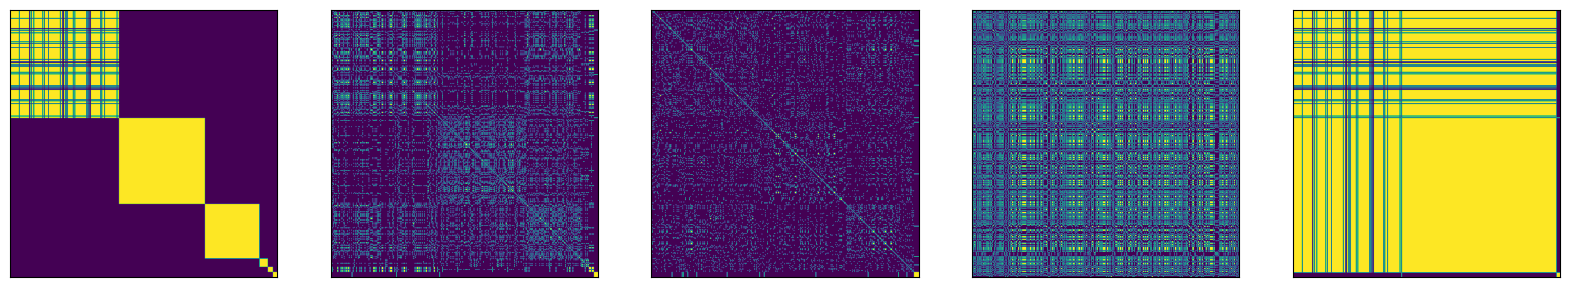

In [ ]:
# show community patterns and their relations
plot_community_patterns([hard_Louv_C_pre,Louv_C_pre, C_soft_louvain_communities_pre, C_b_pre,infomap_C_pre],nrows=1,ncols=5,refs=[0,4])

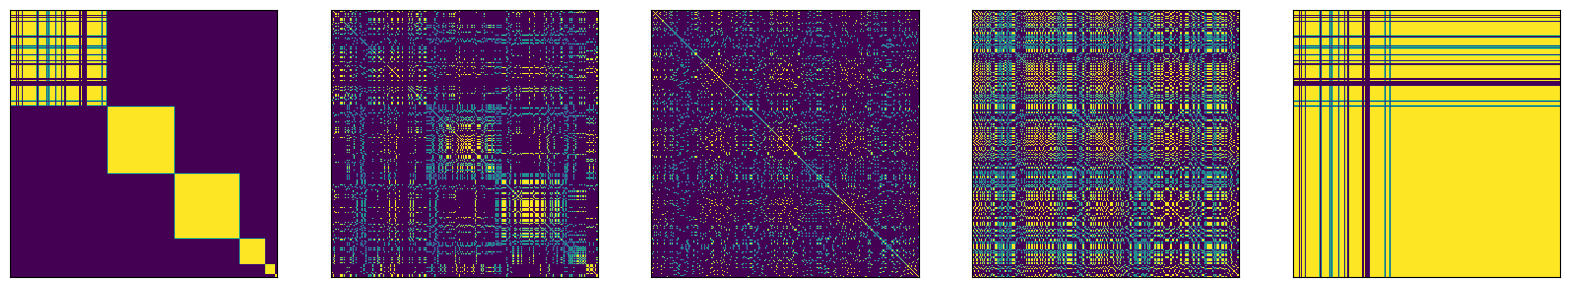

In [ ]:
# show community patterns and their relations
plot_community_patterns([hard_Louv_C_post,Louv_C_post, C_soft_louvain_communities_post, C_b_post,infomap_C_post],nrows=1,ncols=5,refs=[0,4])

Text(0.5, 1.0, 'Infomap')

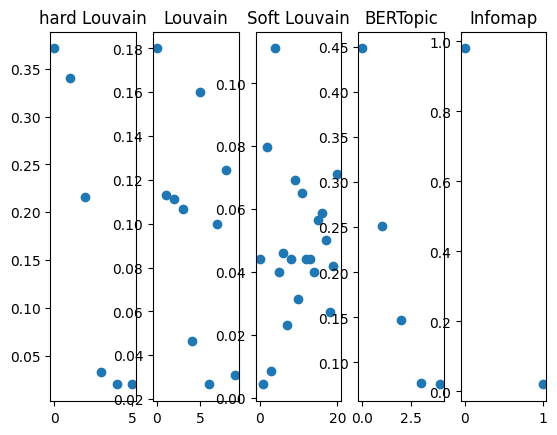

In [ ]:
# show number of documents per community
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.plot(np.array(hard_Louv_C_pre.sum(axis=0)).flatten()/hard_Louv_C_pre.sum(),'o')
ax1.set_title('hard Louvain')
ax2.plot(np.array(Louv_C_pre.sum(axis=0)).flatten()/Louv_C_pre.sum(),'o')
ax2.set_title('Louvain')
ax3.plot(np.array(C_soft_louvain_communities_pre.sum(axis=0)).flatten()/C_soft_louvain_communities_pre.sum(),'o')
ax3.set_title('Soft Louvain');
ax4.plot(np.array(C_b_pre.sum(axis=0)).flatten()/C_b_pre.sum(),'o')
ax4.set_title('BERTopic')
ax5.plot(np.array(infomap_C_pre.sum(axis=0)).flatten()/infomap_C_pre.sum(),'o')
ax5.set_title('Infomap')

Text(0.5, 1.0, 'Infomap')

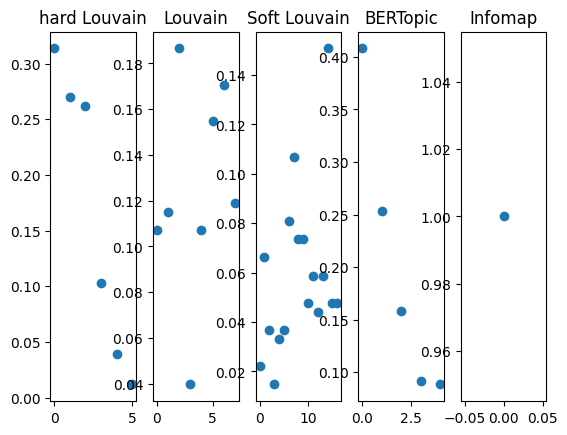

In [ ]:
# show number of documents per community
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.plot(np.array(hard_Louv_C_post.sum(axis=0)).flatten()/hard_Louv_C_post.sum(),'o')
ax1.set_title('hard Louvain')
ax2.plot(np.array(Louv_C_post.sum(axis=0)).flatten()/Louv_C_post.sum(),'o')
ax2.set_title('Louvain')
ax3.plot(np.array(C_soft_louvain_communities_post.sum(axis=0)).flatten()/C_soft_louvain_communities_post.sum(),'o')
ax3.set_title('Soft Louvain');
ax4.plot(np.array(C_b_post.sum(axis=0)).flatten()/C_b_post.sum(),'o')
ax4.set_title('BERTopic')
ax5.plot(np.array(infomap_C_post.sum(axis=0)).flatten()/infomap_C_post.sum(),'o')
ax5.set_title('Infomap')

In [ ]:
print(df_results_pre)

                           algo  c#       NMI         Q      Ncut
0  Networkx Greedy Commmunities   6  0.641877  0.283603  0.503124
1          Louvain Commmunities  10  1.238415  0.326365  0.528936
2                  Soft Louvain  21  1.591211  0.468476  0.452127
3          Infomap Commmunities   2  1.173156  0.116831  0.198376
4                  BERTopic PRE   5  0.635660  0.149853  0.620042


In [ ]:
print(df_results_post)

                           algo  c#       NMI         Q      Ncut
0  Networkx Greedy Commmunities   6  0.914938  0.300561  0.458557
1          Louvain Commmunities   8  1.239677  0.306381  0.500111
2                  Soft Louvain  17  1.499810  0.460089  0.462040
3          Infomap Commmunities   1  1.000000  0.179618  0.000000
4                 BERTopic POST   5  0.725959  0.181988  0.598123


# PT5: SENTIMENT ANALYSIS

In [ ]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
!pip install textblob
from textblob import TextBlob

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def Sentiment_vader(df, column):
    sid = SentimentIntensityAnalyzer()

    sentiments = []
    pos=0
    neu=0
    neg=0
    for post in df[column]:
        # Analyze sentiment
        sentiment_scores = sid.polarity_scores(post)

        # Classify the sentiment
        if sentiment_scores['compound'] >= 0.05:
            sentiment = 'positive'
            pos=pos+1
        elif sentiment_scores['compound'] <= -0.05:
            sentiment = 'negative'
            neg=neg+1
        else:
            sentiment = 'neutral'
            neu=neu+1

        # Store the sentiment and its scores
        sentiments.append({
            'content': post,
            'sentiment': sentiment,
            'Vader': sentiment_scores['compound']
        })
    print("VADER")
    print("positive: "+str(pos))
    print("neutral: "+str(neu))
    print("negative: "+str(neg))

    # Create a new DataFrame to store the sentiment analysis results
    sentiments_df = pd.DataFrame(sentiments)

    sentiment_counts = sentiments_df['sentiment'].value_counts()

    return sentiments_df, sentiment_counts

In [ ]:
def Sentiment_blob(df, column, sentiments_df):

    sentiments_df['blob_polarity'] = df[column].map(lambda text: TextBlob(text).sentiment.polarity)

    pos = (sentiments_df['blob_polarity'] > 0.05).sum()
    neg = (sentiments_df['blob_polarity'] < -0.05).sum()
    neu = ((sentiments_df['blob_polarity'] >= -0.05) & (sentiments_df['blob_polarity'] <= 0.05)).sum()

    sentiment_counts=[pos, neu, neg]
    print("BLOB POLARITY")
    print("positive: "+str(pos))
    print("neutral: "+str(neu))
    print("negative: "+str(neg))

    return sentiments_df, sentiment_counts


In [ ]:
def Show_sentiment(sentiments_df):

    polarity_df = sentiments_df[['Vader', 'blob_polarity']]
    polarity_df = polarity_df.rename(columns={'Vader': 'Vader','blob_polarity': 'TextBlob'})

    plt.figure(figsize=(12, 6))
    sns.histplot(data=polarity_df, bins=40, kde=False, alpha=0.5)
    plt.title('Distributions of sentimental polarities Vader Vs. TextBlob')
    plt.xlabel('Polarity')
    plt.ylabel('Count')

    plt.show()

In [ ]:
##### PRE-CHATGPT #####
sentiments_df_pre, sentiment_counts_pre_vader = Sentiment_vader(pre_chatGPT, 'text_deep_clean')
sentiments_df_pre, sentiment_counts_pre_blob= Sentiment_blob(pre_chatGPT, 'text_deep_clean', sentiments_df_pre)

VADER
positive: 423
neutral: 35
negative: 44
BLOB POLARITY
positive: 106
neutral: 108
negative: 288


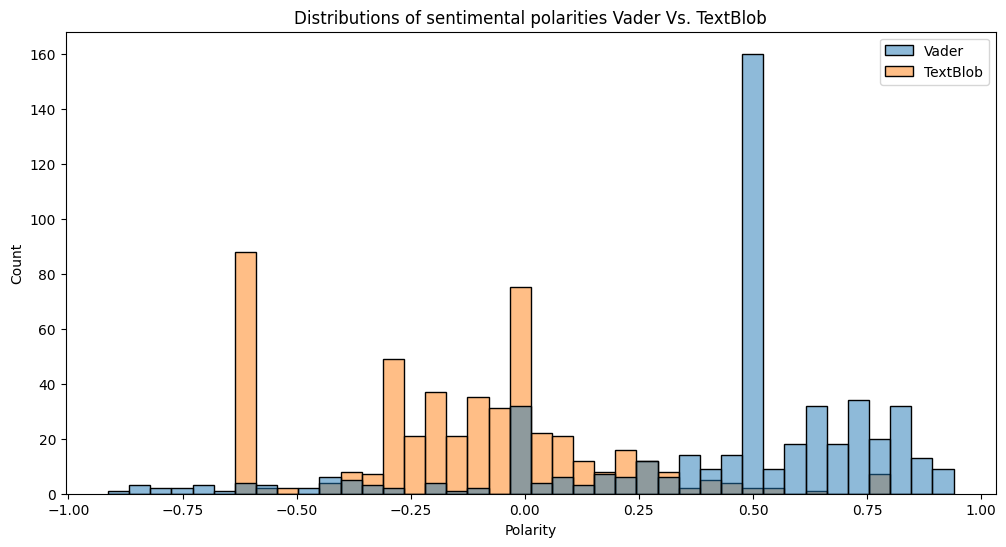

In [ ]:
Show_sentiment(sentiments_df_pre)

In [ ]:
#### POST-CHATGPT #####
sentiments_df_post, sentiment_counts_post_vader = Sentiment_vader(post_chatGPT, 'text_deep_clean')
sentiments_df_post, sentiment_counts_post_blob = Sentiment_blob(post_chatGPT, 'text_deep_clean', sentiments_df_post)

VADER
positive: 176
neutral: 129
negative: 67
BLOB POLARITY
positive: 107
neutral: 168
negative: 97


In [ ]:
post_chatGPT.head()

id    created    subreddit  \
0  z9ndaz 2022-12-01       OpenAI   
1  zb1nmu 2022-12-02  singularity   
2  zcgabn 2022-12-04   artificial   
3  zcfrc1 2022-12-04       OpenAI   
4  zeem4t 2022-12-06   lexfridman   

                                               title  \
0  Top 10 Skills to Learn before AI takes over ac...   
1           Asking ChatGPT to draw its sense of self   
2  Disney Researchers Have Developed An Artificia...   
3  ChatGPT describes how it would take over the w...   
4               Lex helped me appreciate Ben Shapiro   

                                            selftext         author  \
0  Prompt:  top 10 skills to learn before AI take...         uroozz   
1                                                      micahdjt1221   
2                                                          ai-lover   
3  ChatGPT describes how it would take over the w...      cloudd901   
4  Just listened to Lex’s podcast with Ben & for ...  DunAbyssinian   

  author_fullname  upvote_ratio  ups  num_comments  \
0       t2_3x6an8          0.98   50            11   
1      t2_4fcjtj9          0.98  384            52   
2     t2_2wsvqwhg          0.98  298            16   
3        t2_ioo4e          0.99   89            24   
4      t2_d2d5d7p          0.80  121           110   

                                      text_sup_clean  \
0  top skills to learn before ai takes over accor...   
1           asking chatgpt to draw its sense of self   
2  disney researchers have developed an artificia...   
3  chatgpt describes how it would take over the w...   
4               lex helped me appreciate ben shapiro   

                                     text_deep_clean  \
0             top skill learn ai take accord chatgpt   
1                        ask chatgpt draw sense self   
2  disney researcher develop artificial intellige...   
3                        chatgpt describe take world   
4                    lex help appreciate ben shapiro   

                                 text_deep_clean_pos hashtags  
0  [top ADJ, skill NOUN, learn VERB, ai PROPN, ta...      NaN  
1  [ask VERB, chatgpt NOUN, draw VERB, sense NOUN...      NaN  
2  [disney NOUN, researcher NOUN, develop VERB, a...      NaN  
3  [chatgpt NOUN, describe VERB, take VERB, world...      NaN  
4  [lex PROPN, help VERB, appreciate VERB, ben PR...      NaN

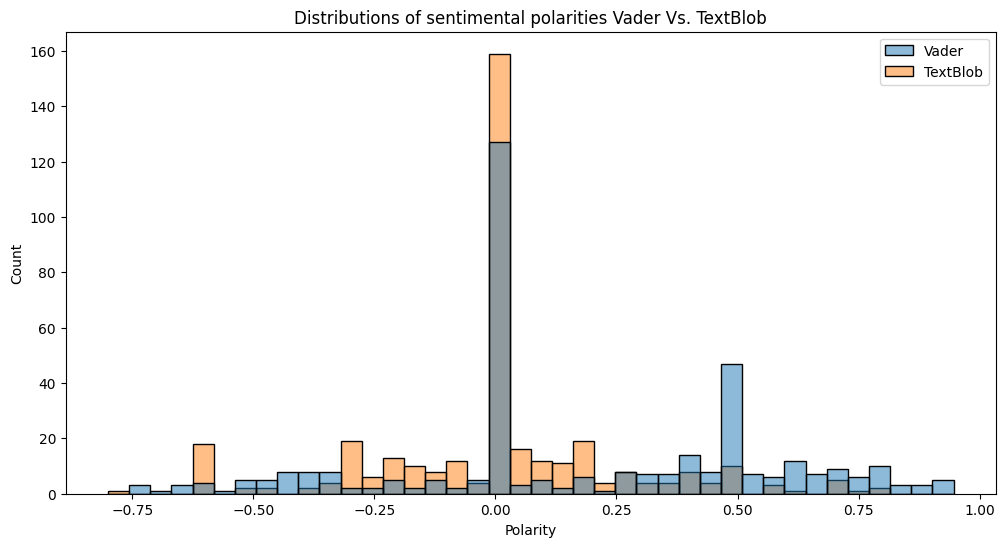

In [ ]:
Show_sentiment(sentiments_df_post)